In [1]:
import numpy as np
import pandas as pd
import datetime

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

2024-06-13 15:58:25.671876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Estilos y reproducibilidad

In [2]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

font_leg = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 10}

# para reproducibilidad
def seeds(seed):
    # python
    import random
    random.seed(seed)

    # numpy
    np.random.seed(seed)

    # tensorflow
    tf.random.set_seed(seed)
    
#seeds(0)
# ó:
#tf.keras.utils.set_random_seed(0)

<center><h1>Elementos de una red neuronal</h1></center>

Ya se ha visto la estructura básica de una red neuronal. Vimos que una neurona realiza una suma ponderada y sobre esta aplica una función de activación que será el valor de salida de la neurona, luego, una vez se han obtenido las predicciones de la red para los datos de entrenamiento, se puede calcular la función de costo que será el objetivo a minimizar por medio del ajuste de los pesos en cada época del entrenamiento. Este ajuste se realiza por medio de algún algoritmo de minimización y, en esencia, todos hacen uso del gradiente de la función de costo. Para calcular este gradiente se debe utilizar un algoritmo muy especial conocido como *El Algoritmo de Backpropagation*. En este notebook se analizarán en mayor detalle cada una de estas componentes del proceso de entrenamiento de la red neuronal. 

<center><h1>Funciones de activación</h1></center>

Una neurona tendrá un determinado número de entradas $x_i$, cada una de ellas un escalar, e internamente realizará una suma ponderada $z=\sum w_ix_i+b$ de estas, luego la suma es entregada a una función de activación $a(z)$ y este será el valor de salida de la neurona. 

Por ejemplo, en el caso del perceptrón propuesto por [Frank Rosenblatt](https://es.wikipedia.org/wiki/Perceptr%C3%B3n), la función de activación es la función escalón unitario, pero tenemos gran variedad de funciones de activación, por ejemplo, keras nos ofrece las siguientes:

<p><center>relu, sigmoid, softmax, softplus, softsign, tanh, selu, elu, exponential, leaky_relu, relu6, silu, hard_silu, gelu, hard_sigmoid, linear, mish, log_softmax.</center></p>

aunque también nos permite definir las nuestras propias. El objetivo de una función de activación es lograr activar las neuronas de modo que la red completa logre aprender. No tener una función de activación en una red, por más grande que sea, hará que toda la red se comporte como si tuviésemos una sola capa. Consideremos la primera capa con función de activación $a^{[1]}(z)$, denotemos por $z^{[1]}$ las sumas ponderadas para cada neurona de la primera capa: 

\begin{equation}
z^{[1]} = w^{[1]}x^{[1]}+b^{[1]} \nonumber
\end{equation}

con $x^{[1]}$ la entrada a la capa $1$. Para la segunda capa sus entradas serían las salidas de la primera capa, es decir $a^{[1]}(z^{[1]})$. No tener función de activación es lo mismo que usar $a(z)=z$, así, para la segunda capa tendríamos que su salida sería:

\begin{eqnarray}
a^{[2]}(z^{[2]}) &=& z^{[2]}\\
                 &=& w^{[2]}x^{[2]}+b^{[2]}\nonumber \\
                 &=& w^{[2]}a^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}z^{[1]}+b^{[2]}\nonumber  \\
                 &=& w^{[2]}[w^{[1]}x^{[1]}+b^{[1]}]+b^{[2]}\nonumber \\
                 &=& w^{[2]}w^{[1]}x^{[1]} + w^{[2]}b^{[1]} +b^{[2]}\nonumber  \\ 
\end{eqnarray}

definiendo $w^{[2]}w^{[1]}=w'$ y $w^{[2]}b^{[1]} +b^{[2]}=b'$ obtenemos

\begin{equation}
a^{[2]}(z^{[2]}) = w'x^{[1]}+b' \nonumber 
\end{equation}

De esta expresión concluimos que la ausencia de una función de activación acabará por hacer que toda la red colapse a una sola capa lineal por lo que no se produce aprendizaje durante el entrenamiento sin importar cuantas capas se utilicen. 

A continuación vamos a comenzar por analizar algunas de las funciones de activación más relevantes y su derivada pues esta es también de alta importancia para poder entender su uso. 

### Lineal
La función de activación más simple sería la función de activación lineal que es una función identidad que, como acabamos de ver, no permite que se produzca aprendizaje en las capas internas de la red.

Veamos su representación gráfica y la de su derivada. Pero antes, como estaremos graficando varias funciones de activación minimicemos código generando una función que haga esto.

In [47]:
def plot_af(x,
            af,
            daf,
            af_ylabel,
            daf_ylabel, **kwards):
    
    # gráfico
    fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

    ax[0].plot(x, af(x, **kwards), color="k", lw=2)
    ax[0].set_title("AF", **font)
    ax[0].set_ylabel(af_ylabel, **font)
    ax[0].set_xlim(min(x), max(x))

    ax[1].plot(x, daf(x), color="red", lw=2)
    ax[1].set_title("Derivative of the AF", **font)
    ax[1].set_ylabel(daf_ylabel, **font_leg)
    ax[1].set_xlim(min(x), max(x))

    plt.tight_layout()
    
    

def plot_accuracy_loss(history, name, accuracy=True, loss=True):
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    if accuracy:
        ax.plot(history["accuracy"],     color="red",   ls="-",  lw=2, label=list(history.keys())[0])
        ax.plot(history["val_accuracy"], color="red",   ls="--", lw=2, label=list(history.keys())[2])
    
    if loss:
        ax.plot(history["loss"],         color="black", ls="-",  lw=2, label=list(history.keys())[1])
        ax.plot(history["val_loss"],     color="black", ls="--", lw=2, label=list(history.keys())[3])

    ax.set_xlim(0, len(history["accuracy"])-1)
    ax.set_xlabel("Ephocs", **font)
    ax.set_ylabel("Score", **font)
    ax.set_title(name, **font)

    ax.legend(prop=font_leg, ncol=2, frameon=False)
    plt.show()

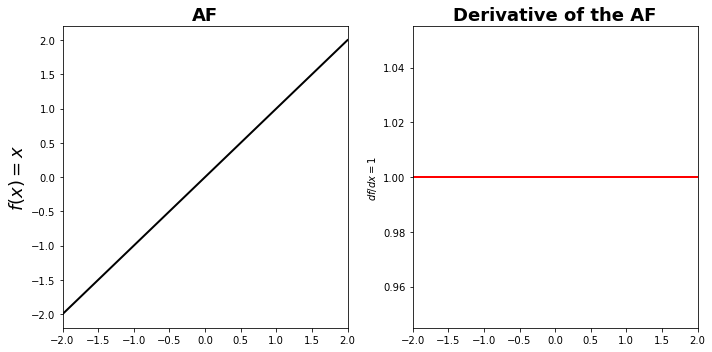

In [48]:
# derivada
x = np.linspace(-2, 2, 100)

def d_lineal(x):
    return 1
d_lineal = np.vectorize(d_lineal)

plot_af(x,
        af=keras.activations.linear,
        daf=d_lineal,
        af_ylabel=f"$f(x)=x$",
        daf_ylabel=f"$df/dx=1$")


Aparte de lo que ya se ha dicho hasta este momento, hay una característica importante que se puede resaltar sobre la función identidad, y es que su derivada es constante, es decir siempre tiene el mismo valor, $1$. Este hecho permite que se pueda producir una actualización constante de los pesos pues, como se verá cuando analicemos el algoritmo de backpropagation, una de las condiciones que tienen que cumplir las funciones de activación es que su derivada no puede ser nula en todos los puntos de su dominio. La derivada de la función de activación es determinante a la hora de entrenar un modelo pues determinará la rapidez con la cual este aprende. 

Esta función de activación es usada principalmente en la última capa de redes para problemas de regresión. 

In [5]:
# Algunos datos de prueba
np.random.seed(0)
xp = np.random.uniform(-10, 10, 10)
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [6]:
keras.activations.linear(xp)

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

Generemos ahora un modelo con múltiples capas para probar el aprendizaje de una red neuronal. 

In [7]:
def create_model(name,
                 shape,
                 layers=4,
                 units=[80, 90, 80, 80],
                 af="relu",
                 output_nodes=10,
                 output_af="softmax"):
    
    # units per layer
    if type(units)==int:
        units=[units]*layers
        
    if len(units)!=layers:
        raise Exception(f"Length of units={len(units)} differs from number of layers={layers}")
        
    @tf.function
    def f(x): return x
    if type(af)==str or type(af)==type(lambda x:x) or type(af)==type(f):
        af=[af]*layers
     
    # layers of the model
    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=shape))
    model.add(keras.layers.Flatten(name="Flatten"))
    
    for i in range(len(units)):
        model.add(keras.layers.Dense(units=units[i], activation=af[i], name=f"layer_{i+1}"))
        
    model.add(keras.layers.Dense(units=output_nodes, activation=output_af, name="output"))
    
    return model

#### Datos

In [8]:
# carga
fm = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fm.load_data()

# normalización
train_images, test_images = train_images/255., test_images/255.

# clases
class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
)

for i, label in enumerate(class_names):
    print(f"{i} --> {label}")
    
train_images.shape, test_images.shape

0 --> T-shirt/top
1 --> Trouser
2 --> Pullover
3 --> Dress
4 --> Coat
5 --> Sandal
6 --> Shirt
7 --> Sneaker
8 --> Bag
9 --> Ankle boot


((60000, 28, 28), (10000, 28, 28))

In [9]:
# modelo
model_fm_linear = create_model(name="fashionmn_af_linear", 
                               shape=train_images[0].shape,
                               af="linear",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_linear.compile(optimizer=opt,
                        loss=loss, metrics=["accuracy"])

model_fm_linear.summary()

2024-06-13 15:58:49.274275: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "fashionmn_af_linear"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_linear = model_fm_linear.fit(train_images,
                                        train_labels,
                                        validation_split=0.2,
                                        epochs=10)

history_fm_linear = history_fm_linear.history

# medimos el tiempo de ejecución
time_fm_linear = datetime.datetime.now() - start
print(f"\nTime to run using linear: {time_fm_linear}")

2024-06-01 13:07:53.894887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7540 - loss: 0.6869 - val_accuracy: 0.8303 - val_loss: 0.4983
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8311 - loss: 0.4882 - val_accuracy: 0.8295 - val_loss: 0.5017
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8333 - loss: 0.4768 - val_accuracy: 0.8400 - val_loss: 0.4570
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8407 - loss: 0.4581 - val_accuracy: 0.8225 - val_loss: 0.5005
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8458 - loss: 0.4431 - val_accuracy: 0.8454 - val_loss: 0.4522
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8471 - loss: 0.4320 - val_accuracy: 0.8476 - val_loss: 0.4416
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8541 - loss: 0.4316 - val_accuracy: 0.8457 - val_loss: 0.4483
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8484 - loss: 0.4280 - 

Lo primero que podemos observar del uso de la función de activación lineal es que las métricas del modelo y su función de costo no mejoran en cada época, contrario a esto parecen oscilar al rededor de un valor promedio. Esto nos muestra de entrada que la elección de esta función de activación para todas las capas no es una buena elección, algo que irémos confirmando a medida que veamos la aplicación de otras funciones de activación. Se debe esperar que el valor de las métricas y la función de costo mejoren en cada época, este no es el caso.

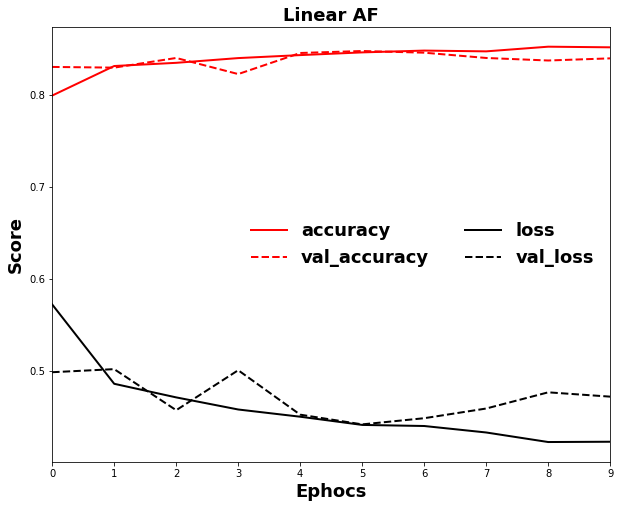

In [11]:
plot_accuracy_loss(history_fm_linear, name="Linear AF")

Como decíamos, las métricas y función de costo varían muy poco en cada iteración, este comportamiento se hará más evidente cuando veamos las otras funciones de activación.

Veamos ahora la capacidad de predicción de este modelo.

In [12]:
# Métricas de testeo
loss_acc_linear_test = model_fm_linear.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8322 - loss: 0.4865


In [13]:
# Métricas de entrenamiento
loss_acc_linear_train = model_fm_linear.evaluate(x=train_images, y=train_labels)

  51/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8813 - loss: 0.4086

2024-06-01 13:08:50.551258: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8515 - loss: 0.4278


### ReLU

[ReLU](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) es una de las funciones de activación más utilizadas para capas ocultas en la actualidad por sus excelentes características a la hora de entrenar. Está definida por

\begin{eqnarray}
    \text{ReLU}(x) = \text{max}(0,x)
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      0 & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

graficamente tenemos

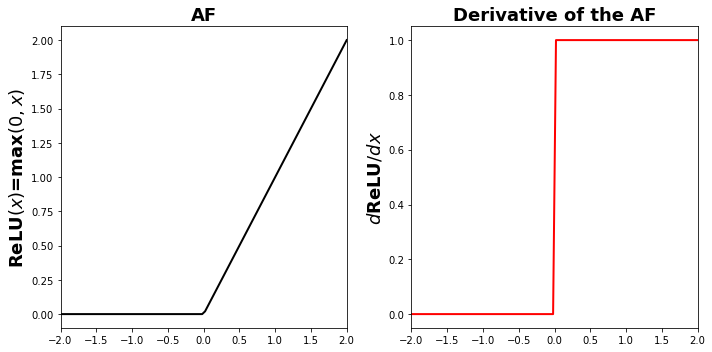

In [14]:
# derivada
x = np.linspace(-2, 2, 100)

def d_relu(x):
    if x<0:
        return 0
    return 1

d_relu = np.vectorize(d_relu)

plot_af(x,
        af=keras.activations.relu,
        daf=d_relu,
        af_ylabel=f"ReLU$(x)$=max$(0,x)$",
        daf_ylabel=f"$d$ReLU$/dx$")


Otras funciones de activación como *tanh* y *sofmax* tienen derivadas que en los extremos tienden a ser nulas y esto genera el conocido como *desvanecimiento del gradiente* que estudiaremos más adelante. La función ReLU, por otro lado, tiene una derivada constante para valores positivos, además de ser una función muy sencilla de calcular comparada con funciones como *tanh* y *sofmax*. Estas características hacen de ella una función de activación altamente utilizada ya que puede acelerar el proceso de aprendizaje de la red. Otro atributo relevante es que genera esparsidad en la red al apagar algunas neuronas (su derivada es cero para valores menores a cero) conduciendo así a una reducción indirecta del overfitting. 

Veamos su comportamiento con algunos datos:

In [15]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [16]:
keras.activations.relu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.97627008, 4.30378733, 2.05526752, 0.89766366, 0.        ,
       2.91788226, 0.        , 7.83546002, 9.27325521, 0.        ])>

Ahora entrenemos un modelo con la misma aquitectura que el modelo anterior pero utilizaremos una función de activación RelU en las capas ocultas. 

In [17]:
# modelo
model_fm_relu = create_model(name="fashionmn_af_relu", 
                               shape=train_images[0].shape, 
                               af="relu",
                               output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_relu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_relu.summary()

Model: "fashionmn_af_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_relu = model_fm_relu.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_relu = history_fm_relu.history
# medimos el tiempo de ejecución
time_fm_relu = datetime.datetime.now() - start
print(f"\nTime to run using relu: {time_fm_relu}")

Epoch 1/10


2024-06-01 13:08:55.125771: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7444 - loss: 0.7038 - val_accuracy: 0.8535 - val_loss: 0.3979
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8577 - loss: 0.3829 - val_accuracy: 0.8531 - val_loss: 0.4102
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8670 - loss: 0.3576 - val_accuracy: 0.8621 - val_loss: 0.3977
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8787 - loss: 0.3250 - val_accuracy: 0.8751 - val_loss: 0.3590
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8879 - loss: 0.3069 - val_accuracy: 0.8770 - val_loss: 0.3437
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8942 - loss: 0.2896 - val_accuracy: 0.8776 - val_loss: 0.3383
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8992 - loss: 0.2764 - val_accuracy: 0.8844 - val_loss: 0.3272
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9017 - loss: 0.2696 - val_accurac

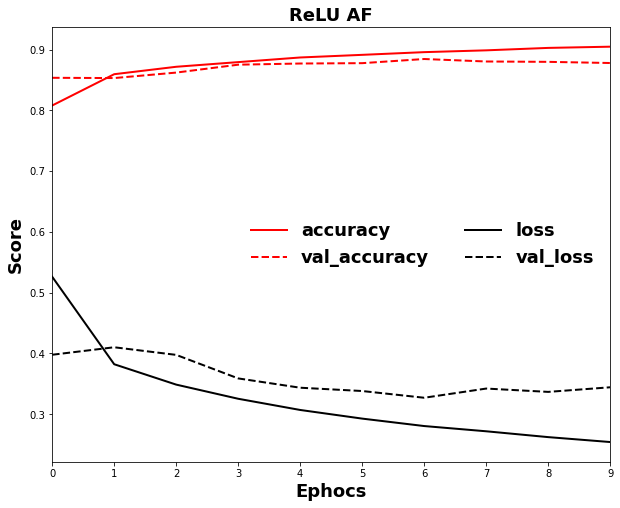

In [19]:
plot_accuracy_loss(history_fm_relu, name="ReLU AF")

En esta ocasión vemos que tanto las métricas como la función de perdida mejoran en cada iteración, contrario a cuando utilizamos la función de activación lineal. 

In [20]:
# Métricas de testeo
loss_acc_relu_test = model_fm_relu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8758 - loss: 0.3590


In [21]:
# Métricas de entrenamiento
loss_acc_relu_train = model_fm_relu.evaluate(x=train_images, y=train_labels)

  53/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9056 - loss: 0.2457

2024-06-01 13:09:51.291380: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9026 - loss: 0.2605


### sigmoide
La función de activación sigmoide o logística está definida por:

\begin{eqnarray}
    \text{sig}(x) = \frac{1}{1+e^{-x}}
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{sig}}{dx} = \text{sig}(x)[1-\text{sig}(x)]
\end{equation}

graficamente tenemos


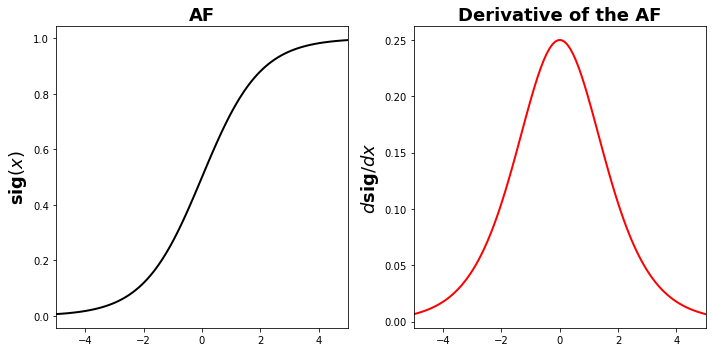

In [22]:
# derivada
x = np.linspace(-5, 5, 100)

def d_sig(x):
    return np.exp(-x)/(1+np.exp(-x))**2

d_sig = np.vectorize(d_sig)

plot_af(x,
        af=keras.activations.sigmoid,
        daf=d_sig,
        af_ylabel=f"sig$(x)$",
        daf_ylabel=f"$d$sig$/dx$")

La función sigmoide sólo puede retornar valores positivos pues está acotada entre $0$ y $1$, esto representa de entrada un problema pues puede restringir los pesos durante el entrenamiento retardando así la velocidad de entrenamiento de la red. Su derivada, diferente a la función de activación ReLU, nunca es nula, pero tiende a serlo para valores alejados de cero de la suma ponderada, por lo cual también sufre del problema del desvanecimiento del gradiente, además su derivada no es tan grande como por ejemplo si lo es la de la función tanh que veremos a continuación. 

La función sigmoide es clasicamente utilizada en la última capa de las redes neuronales cuando se tienen problemas de clasificación binaria. 

In [23]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [24]:
# con sigmoide de keras
keras.activations.sigmoid(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.72636749, 0.98666301, 0.88647879, 0.71046915, 0.17844712,
       0.94872337, 0.22300222, 0.9996047 , 0.99990611, 0.0885742 ])>

In [25]:
# con numpy
1/(1+np.exp(-xp))

array([0.72636749, 0.98666301, 0.88647879, 0.71046915, 0.17844712,
       0.94872337, 0.22300222, 0.9996047 , 0.99990611, 0.0885742 ])

Ahora entrenemos un modelo con una función de activación tanh en las capas ocultas. 

In [26]:
# modelo
model_fm_sig = create_model(name="fashionmn_af_sigm", 
                             shape=train_images[0].shape, 
                             af="sigmoid",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_sig.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_sig.summary()

Model: "fashionmn_af_sigm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_sig = model_fm_sig.fit(train_images,
                                  train_labels,
                                  validation_split=0.2,
                                  epochs=10)

history_fm_sig = history_fm_sig.history

# medimos el tiempo de ejecución
time_fm_sig = datetime.datetime.now() - start
print(f"\nTime to run using sigmoid: {time_fm_sig}")

Epoch 1/10


2024-06-01 13:09:57.691645: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4068 - loss: 1.4904 - val_accuracy: 0.7797 - val_loss: 0.5923
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8051 - loss: 0.5325 - val_accuracy: 0.8332 - val_loss: 0.4647
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8533 - loss: 0.4242 - val_accuracy: 0.8490 - val_loss: 0.4307
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8694 - loss: 0.3755 - val_accuracy: 0.8525 - val_loss: 0.4201
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8751 - loss: 0.3600 - val_accuracy: 0.8693 - val_loss: 0.3750
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8836 - loss: 0.3281 - val_accuracy: 0.8717 - val_loss: 0.3636
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8850 - loss: 0.3203 - val_accuracy: 0.8705 - val_loss: 0.3621
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8914 - loss: 0.3073 - val_accurac

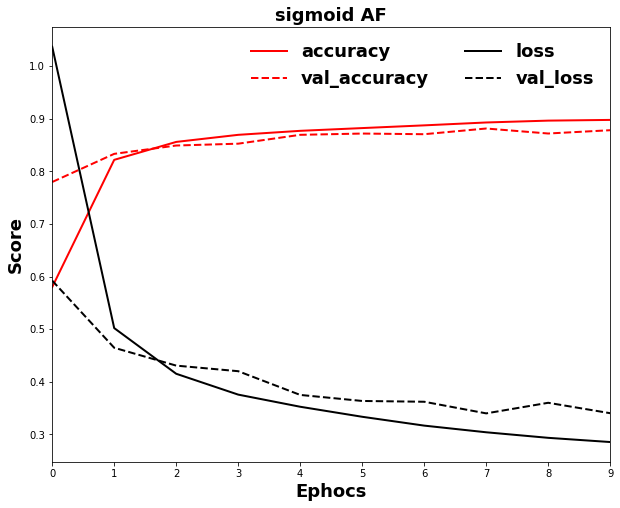

In [28]:
plot_accuracy_loss(history_fm_sig, name="sigmoid AF")

In [29]:
# Métricas de testeo
loss_acc_sig_test = model_fm_sig.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8724 - loss: 0.3580


In [30]:
# Métricas de entrenamiento
loss_acc_sig_train = model_fm_sig.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.2685


### tanh

La función tangente hiperbólica está definida a partir del uso de funciones exponenciales:

\begin{eqnarray}
    \text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{tanh}}{dx} = 1- \text{tanh}^2(x)
\end{equation}

graficamente tenemos

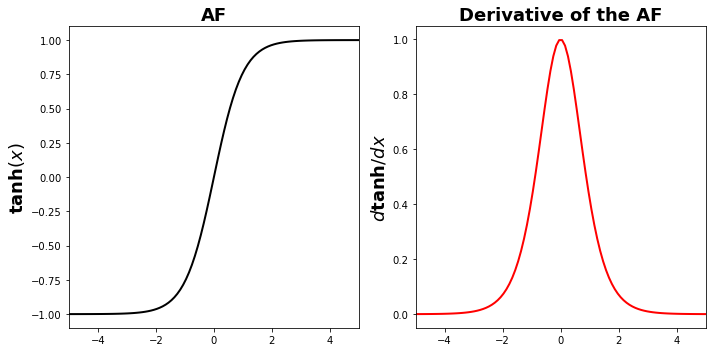

In [31]:
# derivada
x = np.linspace(-5, 5, 100)

def d_tanh(x):
    return 1 - np.tanh(x)**2

d_tanh = np.vectorize(d_tanh)

plot_af(x,
        af=keras.activations.tanh,
        daf=d_tanh,
        af_ylabel=f"tanh$(x)$",
        daf_ylabel=f"$d$tanh$/dx$")

Una primera apreciación importante es que  la $tanh$ tiene un rango que está entre $-1$ y $1$, es decir, puede tomar valores negativos, contrario a las funciones ReLU y sigmoide que solo retornan valores positivos. Esto podría favorecer un entrenamioento más rápido de la red neuronal. Además, al tener una derivada más pronunciada cerca a cero podría acelerar el proceso de entrenamiento siempre  cuando las sumas ponderadas al interior de la neurona permanezcan "pequeños". 

La función tangente hiperbólica presenta una derivada con valores "grandes" cuando está cerca del cero pero tiende a ser nula en los extremos produciendo que el gradiente se desvanezca en esas regiones (más adelante trataremos esto con mayor detalle). Este es un problema para muchas arquitecturas de redes neuronales pues tiende a hacer que la actualización de los pesos se vea frenada cuando la suma ponderada de la neurona es muy grande.

Su uso es recomendado para las capas ocultas de redes neuronales recurrentes (RNN) pues precisamente la característica de que tienda a desvanecer el gradiente ayuda a que este no explote, lo cual puede suceder con relativa facilidad en una RNN al usar otras funciones de activación como ReLU. Por otro lado, no se recomienda su uso en las capas ocultas de redes neuronales profundas pues, aunque tanh puede ser útil en capas ocultas, especialmente en redes neuronales recurrentes, también puede sufrir de saturación en estas redes, lo que puede ralentizar el entrenamiento. 

Tanto la función tanh como la sigmoide se utilizan para problemas de clasificación binarios ubicandolas en la capa de salida de la red. 

In [32]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [33]:
# con tanh de keras
keras.activations.tanh(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.75144671,  0.99963463,  0.96773118,  0.71515836, -0.90989329,
        0.99417464, -0.84779381,  0.99999969,  0.99999998, -0.98128803])>

In [34]:
# con numpy
np.tanh(xp)

array([ 0.75144671,  0.99963463,  0.96773118,  0.71515836, -0.90989329,
        0.99417464, -0.84779381,  0.99999969,  0.99999998, -0.98128803])

Ahora entrenemos un modelo con una función de activación tanh en las capas ocultas. 

In [35]:
# modelo
model_fm_tanh = create_model(name="fashionmn_af_tanh", 
                             shape=train_images[0].shape, 
                             af="tanh",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_tanh.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_tanh.summary()

Model: "fashionmn_af_tanh"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_tanh = model_fm_tanh.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_tanh = history_fm_tanh.history

# medimos el tiempo de ejecución
time_fm_tanh = datetime.datetime.now() - start
print(f"\nTime to run using tanh: {time_fm_tanh}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7786 - loss: 0.6331 - val_accuracy: 0.8537 - val_loss: 0.3984
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8564 - loss: 0.3908 - val_accuracy: 0.8672 - val_loss: 0.3639
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8700 - loss: 0.3518 - val_accuracy: 0.8447 - val_loss: 0.4183
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8800 - loss: 0.3279 - val_accuracy: 0.8742 - val_loss: 0.3445
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8836 - loss: 0.3101 - val_accuracy: 0.8761 - val_loss: 0.3493
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8911 - loss: 0.2949 - val_accuracy: 0.8573 - val_loss: 0.3810
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8942 - loss: 0.2854 - val_accuracy: 0.8724 - val_loss: 0.3478
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8984 - loss: 0.2752 - 

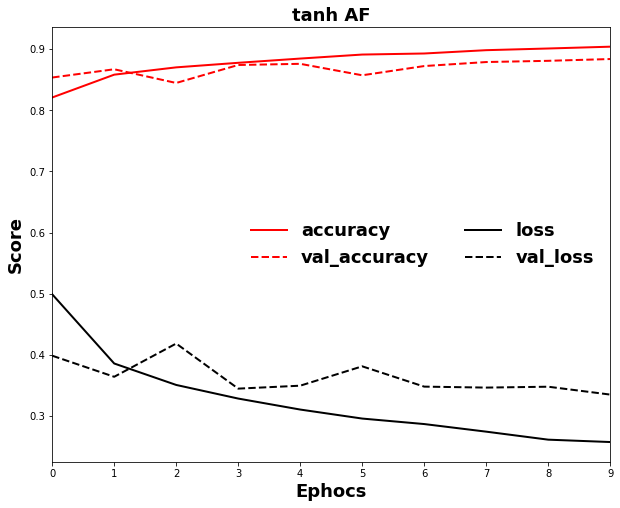

In [37]:
plot_accuracy_loss(history_fm_tanh, name="tanh AF")

In [38]:
# Métricas de testeo
loss_acc_tanh_test = model_fm_tanh.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8749 - loss: 0.3640


In [39]:
# Métricas de entrenamiento
loss_acc_tanh_train = model_fm_tanh.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9096 - loss: 0.2402


### Leaky ReLU

Leaky ReLU es una función de activación que aparece como alternativa para resolver los problemas de ReLU (derivada nula para $x<0$), está definida por:

\begin{eqnarray}
    \text{Leaky ReLU}(x) = \text{max}(\alpha x,x)
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      \alpha & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

donde $\alpha$ es un valor pequeño usualmente 

graficamente tenemos

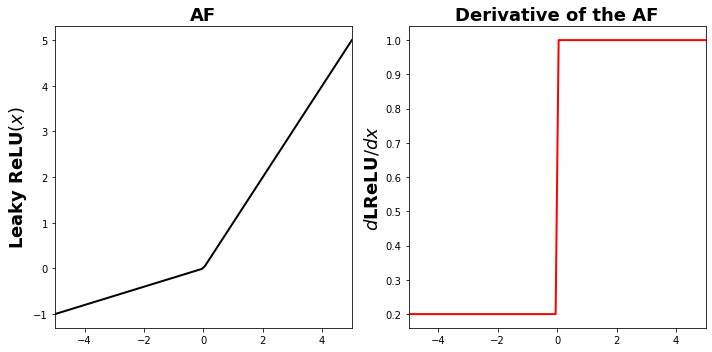

In [40]:
# derivada
x = np.linspace(-5, 5, 100)

alpha = 0.2
def d_lrelu(x, alpha=alpha):
    if x<0:
        return alpha
    return 1

d_lrelu = np.vectorize(d_lrelu)

plot_af(x,
        af=keras.activations.leaky_relu,
        daf=d_lrelu,
        af_ylabel=f"Leaky ReLU$(x)$",
        daf_ylabel=f"$d$LReLU$/dx$", **{"negative_slope":alpha})

En comparación con ReLU, Al permitir un pequeño gradiente para las entradas negativas, Leaky ReLU evita el problema de que algunas neuronas se vuelvan "inactivas", además Leaky ReLU puede ayudar a reducir la probabilidad de que ocurra el desvanecimiento del gradiente en comparación con ReLU, especialmente en redes neuronales más profundas.

Leaky ReLU sigue siendo tema de investigación al igual que muchas otras funciones de activación, por esto no siempre se usa para las capas ocultas y sigue siendo más frecuente el uso de ReLU pero quizá esto cambie conforme avancen los estudios sobre las funciones de activación. 

Una ventaja que tienen tanto ReLU como Leaky ReLU sobre funciones de activación como la logística o tanh que están definidas usando exponenciales y divisiones, es que no son tan costosas computacionalmente hablando, por lo que su uso sigue siendo preferido en las capas ocultas de muhas redes.

In [41]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [42]:
keras.activations.leaky_relu(xp, negative_slope=alpha)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -0.30538081,
        2.91788226, -0.24965116,  7.83546002,  9.27325521, -0.46623393])>

In [43]:
# modelo
model_fm_lrelu = create_model(name="fashionmn_af_lrelu", 
                             shape=train_images[0].shape, 
                             af="leaky_relu",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_lrelu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_lrelu.summary()

Model: "fashionmn_af_lrelu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_lrelu = model_fm_lrelu.fit(train_images,
                                      train_labels,
                                      validation_split=0.2,
                                      epochs=10)

history_fm_lrelu = history_fm_lrelu.history
# medimos el tiempo de ejecución
time_fm_lrelu = datetime.datetime.now() - start
print(f"\nTime to run using leaky relu: {time_fm_lrelu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7581 - loss: 0.6712 - val_accuracy: 0.8340 - val_loss: 0.4534
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8523 - loss: 0.4010 - val_accuracy: 0.8653 - val_loss: 0.3671
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8712 - loss: 0.3545 - val_accuracy: 0.8708 - val_loss: 0.3569
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8775 - loss: 0.3320 - val_accuracy: 0.8703 - val_loss: 0.3546
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8808 - loss: 0.3175 - val_accuracy: 0.8766 - val_loss: 0.3494
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8871 - loss: 0.3039 - val_accuracy: 0.8746 - val_loss: 0.3354
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8919 - loss: 0.2838 - val_accuracy: 0.8787 - val_loss: 0.3292
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8954 - loss: 0.2788 -

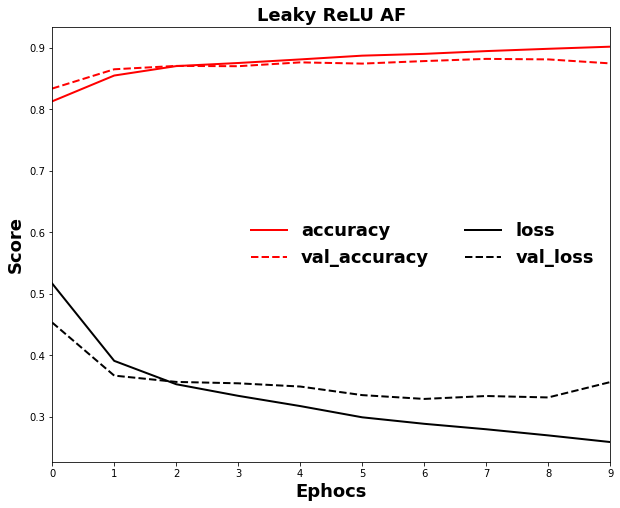

In [45]:
plot_accuracy_loss(history_fm_lrelu, name="Leaky ReLU AF")

In [46]:
# Métricas de testeo
loss_acc_lrelu_test = model_fm_lrelu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8638 - loss: 0.3765


In [47]:
# Métricas de entrenamiento
loss_acc_lrelu_train = model_fm_lrelu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8967 - loss: 0.2688


### ELU
El estudio de las funciones de activación es un campo bastante activo, entre las últimas propuestas tenemos ELU, Exponential Linear Units, definida como:

\begin{eqnarray}
    \text{ELU}(x) = \left\{ \begin{array}{lcc} 
                                                      \alpha(e^x-1) & si & x < 0 \\
                                                      x  & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ReLU}}{dx} = \left\{ \begin{array}{lcc} 
                                                      \alpha e^x & si & x < 0 \\
                                                      1 & si & x \geq 0     \\
                                   \end{array}
                           \right.
\end{equation}

donde $\alpha$ es un parámetro que se suele establecer igual $1$.

graficamente tenemos

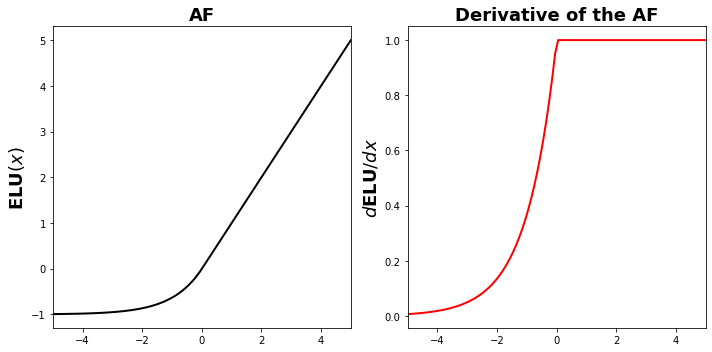

In [48]:
# derivada
x = np.linspace(-5, 5, 100)

alpha = 1
def d_elu(x, alpha=alpha):
    if x<0:
        return alpha*np.exp(x)
    return 1

d_elu = np.vectorize(d_elu)

plot_af(x,
        af=keras.activations.elu,
        daf=d_elu,
        af_ylabel=f"ELU$(x)$",
        daf_ylabel=f"$d$ELU$/dx$", **{"alpha":alpha})

Al igual que Leaky ReLU, ELU viene a solventar algunos de los problemas de ReLU como lo son las neuronas muertas. A diferencia de Leaky ReLu, ELU es más suave por lo que su derivadda  también tiende a serlo permitiendo un mejor entrenamiento en capas ocultas. Aún así, ELU es computacionalmente más costosa por la presencia del exponencial. 

In [49]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [50]:
keras.activations.elu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -0.7827929 ,
        2.91788226, -0.71299504,  7.83546002,  9.27325521, -0.90281799])>

In [51]:
# modelo
model_fm_elu = create_model(name="fashionmn_af_elu", 
                            shape=train_images[0].shape, 
                            af="elu",
                            output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_elu.compile(optimizer=opt,
                     loss=loss,
                     metrics=["accuracy"])

model_fm_elu.summary()

Model: "fashionmn_af_elu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_elu = model_fm_elu.fit(train_images,
                                  train_labels,
                                  validation_split=0.2,
                                  epochs=10)

history_fm_elu = history_fm_elu.history

# medimos el tiempo de ejecución
time_fm_elu = datetime.datetime.now() - start
print(f"\nTime to run using elu: {time_fm_elu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7696 - loss: 0.6343 - val_accuracy: 0.8366 - val_loss: 0.4521
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8556 - loss: 0.3902 - val_accuracy: 0.8627 - val_loss: 0.3814
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8687 - loss: 0.3476 - val_accuracy: 0.8587 - val_loss: 0.3775
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8803 - loss: 0.3235 - val_accuracy: 0.8635 - val_loss: 0.3686
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8846 - loss: 0.3064 - val_accuracy: 0.8655 - val_loss: 0.3692
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8936 - loss: 0.2845 - val_accuracy: 0.8865 - val_loss: 0.3196
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8979 - loss: 0.2711 - val_accuracy: 0.8799 - val_loss: 0.3397
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9024 - loss: 0.2590 - 

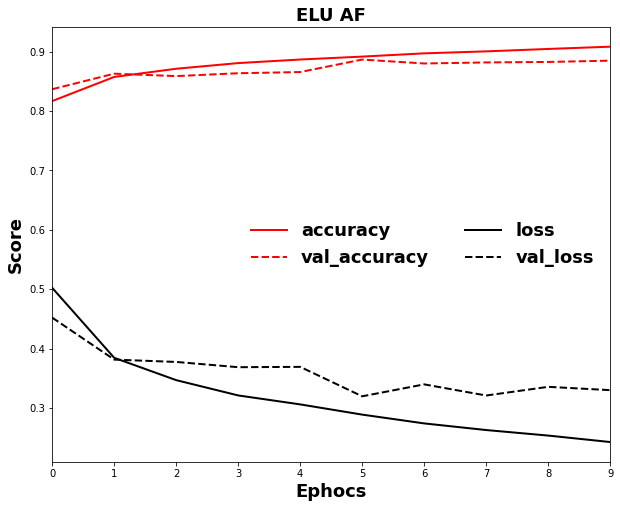

In [53]:
plot_accuracy_loss(history_fm_elu, name="ELU AF")

In [54]:
# Métricas de testeo
loss_acc_elu_test = model_fm_elu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8692 - loss: 0.3519


In [55]:
# Métricas de entrenamiento
loss_acc_elu_train = model_fm_elu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9101 - loss: 0.2289


### GELU
Finalmente vemos la función de activación [GELU](https://arxiv.org/pdf/1606.08415), esá definida como:

\begin{eqnarray}
    \text{ELU}(x) = \frac{x}{2}\left[ 1 + \text{erf}(x/\sqrt{2}) \right]
\end{eqnarray}

Por lo cual su derivada es:

\begin{equation}
 \frac{d\text{ELU}}{dx} = \frac{1}{2}\left[ 1 + \text{erf}(x/\sqrt{2}) \right] + \frac{x}{\sqrt{2\pi}}e^{-x^2/2}
\end{equation}

graficamente tenemos

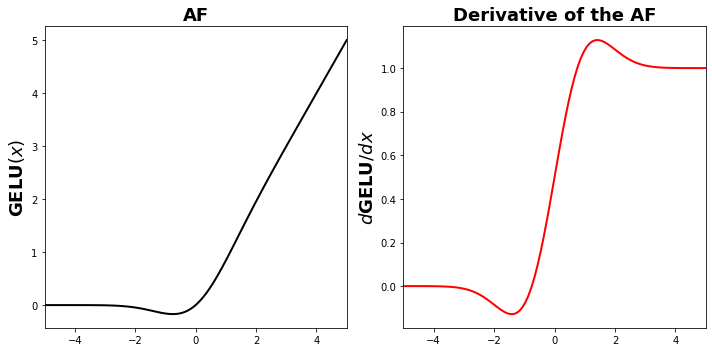

In [56]:
# derivada
from scipy.special import erf

x = np.linspace(-5, 5, 100)

def d_gelu(x):
    return 0.5*(1+erf(x/np.sqrt(2))) + x*np.exp(-x**2/2)/np.sqrt(2*np.pi)

d_gelu = np.vectorize(d_gelu)

plot_af(x,
        af=keras.activations.gelu,
        daf=d_gelu,
        af_ylabel=f"GELU$(x)$",
        daf_ylabel=f"$d$GELU$/dx$")

Una característica que claramente distingue a GELU de las otras funciones de activación es que no es monótona. Al no serlo, GELU puede capturar relaciones no lineales más complejas entre las características de entrada y la salida de la red neuronal. Esto significa que puede adaptarse mejor a la complejidad de los datos, lo que potencialmente puede llevar a un mejor rendimiento del modelo.
Además, su falta de monotonía permite que la función de activación capture relaciones no lineales más complejas en los datos, lo que lleva a un mejor rendimiento del modelo y una mejor capacidad para modelar la variabilidad de los datos del mundo real.

UNa gran desventaja de esta función de activación es que es muy costosa computacionalmente devido a la presencia de la función de error que es bastante compleja de calcular. 

In [57]:
xp

array([ 0.97627008,  4.30378733,  2.05526752,  0.89766366, -1.52690401,
        2.91788226, -1.24825577,  7.83546002,  9.27325521, -2.33116962])

In [58]:
keras.activations.gelu(xp)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 0.81570751,  4.3037512 ,  2.01431306,  0.73188094, -0.09679417,
        2.9127407 , -0.13227604,  7.83546002,  9.27325521, -0.02301379])>

In [59]:
# modelo
model_fm_gelu = create_model(name="fashionmn_af_gelu", 
                             shape=train_images[0].shape, 
                             af="gelu",
                             output_af="softmax")

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_fm_gelu.compile(optimizer=opt,
                      loss=loss,
                      metrics=["accuracy"])

model_fm_gelu.summary()

Model: "fashionmn_af_gelu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Entrenamiento 
start = datetime.datetime.now()
history_fm_gelu = model_fm_gelu.fit(train_images,
                                    train_labels,
                                    validation_split=0.2,
                                    epochs=10)

history_fm_gelu = history_fm_gelu.history

# medimos el tiempo de ejecución
time_fm_gelu = datetime.datetime.now() - start
print(f"\nTime to run using gelu: {time_fm_gelu}")

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7567 - loss: 0.6742 - val_accuracy: 0.8553 - val_loss: 0.3951
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8611 - loss: 0.3772 - val_accuracy: 0.8612 - val_loss: 0.3762
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8713 - loss: 0.3456 - val_accuracy: 0.8737 - val_loss: 0.3611
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8837 - loss: 0.3130 - val_accuracy: 0.8668 - val_loss: 0.3554
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8928 - loss: 0.2873 - val_accuracy: 0.8822 - val_loss: 0.3320
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8987 - loss: 0.2714 - val_accuracy: 0.8876 - val_loss: 0.3139
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9045 - loss: 0.2537 - val_accuracy: 0.8832 - val_loss: 0.3289
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9072 - loss: 0.2438 - 

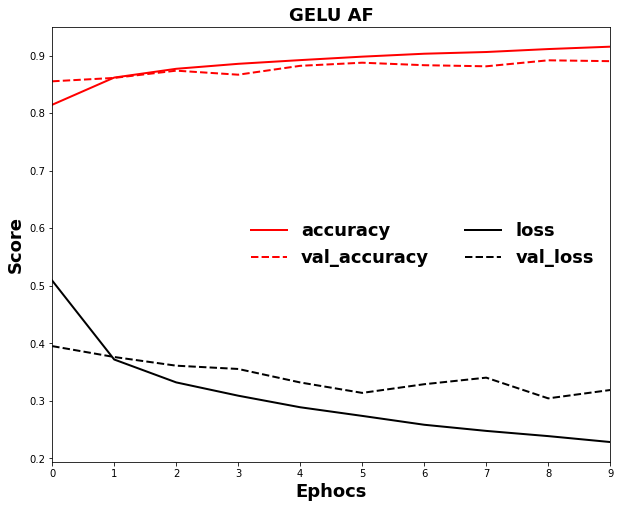

In [61]:
plot_accuracy_loss(history_fm_gelu, name="GELU AF")

In [62]:
# Métricas de testeo
loss_acc_gelu_test = model_fm_gelu.evaluate(x=test_images, y=test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3415


In [63]:
# Métricas de entrenamiento
loss_acc_gelu_train = model_fm_gelu.evaluate(x=train_images, y=train_labels)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9237 - loss: 0.1983


### Comparación entre las funciones de activación
Ahora analicemos un poco los resultados obtenidos con cada función de activación.

In [64]:
af_info = {"linear":     [time_fm_linear.total_seconds(), *loss_acc_linear_train, *loss_acc_linear_test],
           "sigmoid":    [time_fm_sig.total_seconds(),    *loss_acc_sig_train,    *loss_acc_sig_test],
           "tanh":       [time_fm_tanh.total_seconds(),   *loss_acc_tanh_train,   *loss_acc_tanh_test],
           "ReLU":       [time_fm_relu.total_seconds(),   *loss_acc_relu_train,   *loss_acc_relu_test],
           "Leaky ReLU": [time_fm_lrelu.total_seconds(),  *loss_acc_lrelu_train,  *loss_acc_lrelu_test],
           "ELU":        [time_fm_elu.total_seconds(),    *loss_acc_elu_train,    *loss_acc_elu_test],
           "GELU":       [time_fm_gelu.total_seconds(),   *loss_acc_gelu_train,   *loss_acc_gelu_test]
           }

af_info = pd.DataFrame(af_info, index=["time", "loss_train", "accuracy_train", "loss_test", "accuracy_test" ]).T
af_info = af_info.sort_values(by="time", ascending=True)
af_info

,time,loss_train,accuracy_train,loss_test,accuracy_test
sigmoid,53.345955,0.282255,0.897200,0.365571,0.8702
ReLU,54.727049,0.276224,0.898750,0.366958,0.8705
tanh,55.174352,0.259152,0.904850,0.365886,0.8735
linear,55.326859,0.438381,0.847933,0.500709,0.8282
ELU,61.172683,0.249036,0.905167,0.356923,0.8694
Leaky ReLU,62.798327,0.284587,0.893317,0.380324,0.8662
GELU,66.346831,0.221259,0.918000,0.339062,0.8862


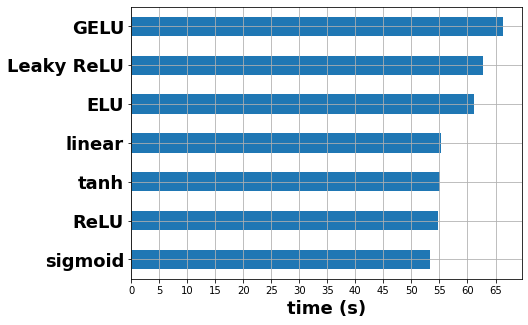

In [65]:
fig, ax = plt.subplots(figsize=(7,5))
af_info.time.plot(kind="barh", ax=ax)

ax.set_yticklabels(af_info.index, rotation=0, **font)
ax.set_xticks(ticks=np.arange(0,66,5))
ax.set_xlabel("time (s)", **font)
ax.grid()
plt.show()

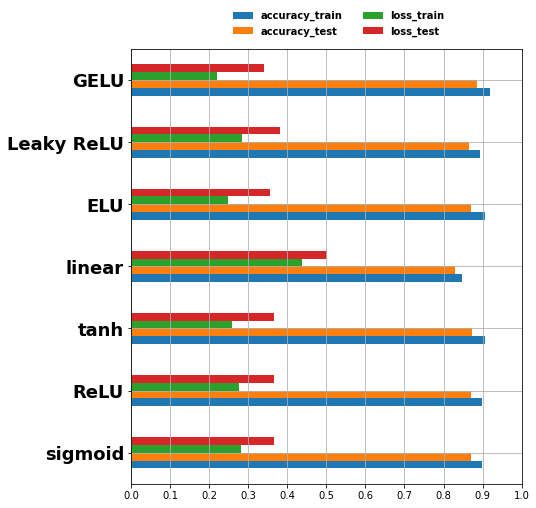

In [66]:
fig, ax = plt.subplots(figsize=(7,8))
af_info.loc[:, ["accuracy_train",
                "accuracy_test",
                "loss_train",
                "loss_test" ]].plot(kind="barh", ax=ax)

ax.set_yticklabels(af_info.index, rotation=0, **font)
ax.set_xticks(ticks=np.linspace(0,1,11))
ax.legend(loc=(0.25, 1.02), ncol=2, prop=font_leg, frameon=False)
ax.grid()
plt.show()

¿Cómo se comparan las funciones de activación entre ellas?

### Definiendo nuestra propia función de activación

En caso que precisemos crear nuestras propias funciones de activación lo podemos hacer de diferentes maneras:
* Definiendo la función de activación
* Igual que el método anterior pero utilizando el decorador <code>@tf.function</code>.
* Usando una función/capa lambda.

También es posible escribir la función de activación como una clase que hereda de <code>Layer</code> en casos más complejos, por ejemplo, si queremos que nuestra función de activación sea una capa con algunos parámetros que también queremos optimizar en el proceso de entrenamiento. En este curso no veremos este método. 

La función de activación que se defina, con cualquiera de los métodos, debe recibir un tensor y retornar otro con iguales dimensiones. Una manera sencilla de hacer esto es por medio del módulo <code>tf.math</code>, también se puede hacer uso del backend de Keras (en este caso sería TensorFlow) con <code>keras.backend</code> o simplemente usar las funciones matemáticas directamente definidas en TensorFlow. Por ejemplo, si queremos aplicar la función seno tendríamos tres opciones:

* <code>tf.sin(x)</code>
* <code>tf.math.sin(x)</code>
* <code>keras.backend.sin(x)</code>

Cuál de los métodos usar depende parcialmente del programador. Se sugiere el uso del módulo <code>tf.math</code> por ser sintácticamente más explícito.

#### Definiendo la función de activación.

In [67]:
def custom_af_1(x):
    # Habría diferencia en el uso de * vs tf.multiply si alguno
    # de los tensores fuese  tf.sparse.SparseTensor.
    
    #return tf.math.sin(x)*tf.math.cos(x)
    return tf.multiply(tf.math.sin(x), tf.math.cos(x))
    

model_custom_af_1 = create_model(name="custom_af_1",
                                 shape=train_images[0].shape, 
                                 af=custom_af_1)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custom_af_1.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custom_af_1.summary()

Model: "custom_af_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
"""
# Entrenamiento 
history_custom_af_1 = model_custom_af_1.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=2)

history_custom_af_1 = history_custom_af_1.history
"""
print()

#### Utilizando el decorador <code>@tf.function</code>

In [69]:
@tf.function
def custom_af_2(x):
    return tf.where(tf.less(x, 0.0), 
                   -tf.math.sqrt(tf.multiply(-1.0, x)),
                    x
                   )

model_custom_af_2 = create_model(name="custom_af_2",
                                 shape=train_images[0].shape, 
                                 af=custom_af_2)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custom_af_2.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custom_af_2.summary()

Model: "custom_af_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
"""
# Entrenamiento 
history_custom_af_2 = model_custom_af_2.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=2)

history_custom_af_2 = history_custom_af_2.history
"""
print()

In [71]:
"""
# derivada
x = np.linspace(-5, 5, 100, dtype=np.float32)

def d_custom2(x):
    if x<0:
        return 0.5*(-x)**(-0.5)
    return 1

d_custom2 = np.vectorize(d_custom2)

plot_af(x,
        af=custom_af_2,
        daf=d_custom2,
        af_ylabel=f"Custom$(x)$",
        daf_ylabel=f"$d$Custom$/dx$")
"""
print()

Como se puede ver, la diferencia entre estos dos métodos es sólo el uso del decorador <code>@tf.function</code>.  Usarlo puede mejorar el rendimiento y la eficiencia de la función de activación personalizada, ya que se compila en TensorFlow antes de la ejecución, esto puede ser especialmente beneficioso en modelos con grandes cantidades de datos y/o capas. Esta es la forma sugerida para definir nuevas funciones de activación.

#### Usando una función lambda

In [72]:
custum_af_3 = lambda x: keras.backend.sin(x)

model_custum_af_3 = create_model(name="custum_af_3",
                                 shape=train_images[0].shape, 
                                 af=custum_af_3)

opt  = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model_custum_af_3.compile(optimizer=opt,
                          loss=loss,
                          metrics=["accuracy"])

model_custum_af_3.summary()

Model: "custum_af_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,660 (330.70 KB)

 Trainable params: 84,660 (330.70 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
"""
# Entrenamiento 
history_custum_af_3 = model_custum_af_3.fit(train_images,
                                            train_labels,
                                            validation_split=0.2,
                                            epochs=10)

history_custum_af_3 = history_custum_af_3.history
"""
print()

<center><h1>Funciones de perdida</h1></center>

Después de cada época se analiza el resultado arrojado por la red utilizando alguna función que de cuenta de su desempeño general, de modo que un menor valor de dicha función representa un mejor comportamiento de la red, es decir, mejores métricas de desempeño del modelo. Esta función recibe el nombre de función de costo (o perdida) y es el objetivo a minimizar para cualquier red neuronal: todas las redes neuronales representan un problema de minimización de una función de costo. En el proceso de minimización se utilizan principalmente dos herramientas que veremos en las dos siguientes secciones: el **gradiente descendente** y el algoritmo de **back propagation**. 
     

Al igual que las funciones de activación, las funciones de costo deben cumplir con ciertos requisitos, entre ellos el que más resalta es la diferenciabilidad que se debe dar en todo su dominio salvo algunos puntos de menor interes como $w_i=0$ para todos los pesos. Como veremos más adelante, esto proviene del algoritmo de *back propagation* y del *gradiente descendente* que requieren ambas, funciones de activación y funciones de costo diferenciables para poder actualizar los pesos y así producir aprendizaje en la red.

La función de costo se entrega al modelo durante la etapa de compilación, tenemos dos opciones:

* **Creando una instancia.** Este método es el sugerido pues nos permite ajustar los parámetros de la función
    de costo según lo requiramos. 
    
* **Usando el alias.**. Durante la etapa de compilación podemos pasar simplemente el alias de la función
    de perdida que queramos usar. Por ejemplo, si queremos implementar como función de perdida 
    <code>tf.keras.losses.CategoricalCrossentropy()</code> podemos simplemente pasar <code>loss="categorical_crossentropy"</code>
    
    
Dependiendo del tipo de problema que se esté afrontando se utilizará una u otra función de perdida, entre las más comunes tenemos:

* **Regresión:**
    * <code>tf.keras.losses.MeanSquaredError()</code>
    * <code>tf.keras.losses.MeanAbsolutePercentageError()</code>
    * <code>tf.keras.losses.MeanAbsolutePercentageError()</code>
    * <code>tf.keras.losses.MeanSquaredLogarithmicError()</code>
    
    
* **Clasificación binaria:**
    * <code>tf.keras.losses.BinaryCrossentropy()</code>
    
    
* **Clasificación multiclase:**
    * <code>tf.keras.losses.CategoricalCrossentropy()</code>
    * <code>tf.keras.losses.SparseCategoricalCrossentropy()</code>
    * <code>tf.keras.losses.Poisson()</code>
    * <code>tf.keras.losses.Hinge()</code>
    
Un concepto con el que nos vamos a topar con frecuencia es el de **batch**, veamos a qué se refiere.

#### ¿Qué es un batch?

Supongamos que tenemos un conjunto de entrenamiento con un cierto número de muestras. Una primera aproximación, intuitiva, para realizar el entrenamiento de la red, sería pasar cada muestra por la red y obtener la predicción, luego comparar con el valor verdadero utilizando la función de costo y finalmente realizar la actualización de los pesos de la red, esto para cada muestra. Este proceso es muy costoso computacionalmente pues implica la actualización de los pesos de la red por cada época tantas veces como muestras se tenga, además puede llevar a más problemas como el overfiting. Para manejar esta situación se utiliza la idea de lotes (o batches). Un batch consiste en tomar un un conjunto de muestras, realizar las predicciones para cada una de ellas, aplicar la función de costo y finalmente la actualización de los pesos. Este procedimiento requiere menos poder de computo y es mucho más beneficioso temporalmente pues puede ser paralelizable. 

El batch puede ser de múltiples tamaños, por ejemplo, podríamos elegirlo de tamaño $1$, en este caso se realiza la actualización de los pesos por cada muestra. También podríamos elegirlo de igual tamaño al conjunto de entrenamiento, es decir sólo se actualizarán los pesos una vez hayan pasado todas las muestras por la red. Valores habituales son $32$, $64$, $128$, ... Por ejemplo, en los modelos que corrimos anteriormente podíamos ver algo como esto: 

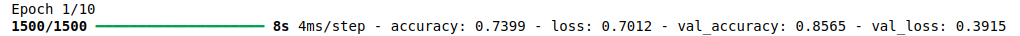

Veamos cuál era el tamaño del conjunto de entrenamiento:

In [74]:
train_images.shape

(60000, 28, 28)

Recordemos que usamos el $20\%$ de datos para validación:

In [75]:
real_training_size = train_images.shape[0]*0.8
real_training_size

48000.0

Este es el número de imágenes utilizado para entrenar el modelo. Por defecto se utilizan $32$ batches. Por lo tanto en cada época se tendrá el siguiente número de batches:

In [76]:
int(real_training_size/32)

1500

Que coincide justo con el valor que aparece debajo del índice de la época. Ahora que sabemos cómo se ejecuta una función de costo podemos comenzar a analizar las más importantes.

## Funciones de perdida para problemas de regresión

Para crear una instancia de una función de perdida podemos hacerlo ya sea accediendo directamente al módulo <code>tf.keras.losses</code> o utilizando <code>tf.losses</code>. Ambos son equivalentes pero en caso de no querer trabajar con Keras entonces el uso del módulo directamente desde TensorFlow es sugerido.

### MSE
El error cuadrático medio está definido por:

\begin{equation}
\text{MSE} = \frac{1}{n}\sum_{i=1}^n \left( y_i - \hat y_i \right)^2
\end{equation}

Donde $n$ es el número de pruebas, $y_i$ es el verdadero valor y $\hat y_i$ es el valor predicho por el modelo. El MSE es una de las métricas más ampliamente utilizadas para problemas de regresión debido a que es muy fácil de interpretar. El MSE es sugerido para controlar aquellas predicciones que se alejan mucho de la media ya que estas son fuertemente penalizados por tener una mayor distancia al modelo, es decir, porque su valor real se aleja mucho del valor predicho. Se sugiere su uso para datos que estén normalmente distribuídos. 

Al instanciar la función de perdida podemos definir el valor del parámetro <code>reduction</code>, este especifica la manera en que los valores de la función de perdida van a ser agregados.

In [77]:
# https://python.plainenglish.io/the-complete-guide-to-keras-loss-functions-776d319e729d
# https://medium.com/@abayomiajiboye46111/understanding-the-class-of-losses-in-tensorflow-for-deep-learning-4bd71c8e52a7

# Algunos datos de prueba. 
# Se generan 10 batches, cada uno con 4 muestras, para un total de 40 muestras.
np.random.seed(123)
y_true = np.random.uniform(1, 30, (10,4))
y_pred = np.random.uniform(1, 30, (10,4))

y_true

array([[21.19760638,  9.29804071,  7.57869215, 16.9881283 ],
       [21.86460012, 13.27008734, 29.44216175, 20.86006242],
       [14.94702514, 12.37140803, 10.95216247, 22.14244151],
       [13.7185951 ,  2.730659  , 12.5432834 , 22.40186677],
       [ 6.29226018,  6.08810093, 16.41498984, 16.42300003],
       [19.3976278 , 25.63352203, 22.00920442, 18.71968181],
       [21.95085809, 10.3658085 , 11.49187101,  7.6196337 ],
       [ 9.51770735, 19.29830759,  3.67104326, 13.57733401],
       [13.49502014, 15.31686783, 13.34907842, 10.05557547],
       [13.3641879 , 26.90828573, 28.38064053, 15.5532636 ]])

* <code>reduction="sum_over_batch_size"</code> es el valor por defecto. Aplica la función de costo sobre cada batch y luego promedia el valor de todos los batches.

In [78]:
loss_mse = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")
loss_mse(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=74.37765>

In [79]:
np.mean(np.mean((y_true-y_pred)**2, axis=1))

74.37764942365501

* <code>reduction="sum"</code>. Suma los valores de la función de perdida en cada batch. Diferente al caso anterior no los promedia.

In [80]:
loss_mse = keras.losses.MeanSquaredError(reduction="sum")
loss_mse(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=743.7765>

In [81]:
np.sum(np.mean((y_true-y_pred)**2, axis=1))

743.7764942365502

* <code>reduction=None"</code>. Aplica la función de costo sobre cada batch y retorna el resultado de cada uno.

In [82]:
loss_mse = keras.losses.MeanSquaredError(reduction=None)
loss_mse(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 12.85541 ,  81.90165 ,  22.964052,  95.44571 ,  90.32697 ,
        17.789778,  49.11834 ,  45.687687,  71.23675 , 256.45013 ],
      dtype=float32)>

In [83]:
np.mean((y_true-y_pred)**2, axis=1)

array([ 12.85540717,  81.90164489,  22.96405328,  95.44570617,
        90.32695795,  17.78978108,  49.11833521,  45.68768549,
        71.2367478 , 256.4501752 ])

### MAE
El error absoluto medio está definido por:

\begin{equation}
\text{MAE} = \frac{1}{n}\sum_{i=1}^n \left| y_i - \hat y_i \right|
\end{equation}

Similar al MSE pero computa la media de las distancias entre el valor real y el obtenido, no sus distancias cuadráticas. Esta métrica no es tan sensible a outliers como sí lo es MSE. En el caso en que tengamos un problema en el cual los residuales no tiendan a estar distribuidos normalmente MAE puede ser una mejor opción que MSE. 

Otra forma de determinar el método de reducción es usando la clase <code>keras.losses.Reduction</code> 

In [84]:
loss_mae = keras.losses.MeanAbsoluteError(reduction=keras.losses.Reduction.NONE)
loss_mae(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 3.4072087,  8.105146 ,  4.1989875,  8.257989 ,  8.016254 ,
        3.346784 ,  5.6329627,  4.4460154,  8.105422 , 13.40993  ],
      dtype=float32)>

In [85]:
# Con numpy
np.mean(np.absolute(y_true-y_pred), axis=1)

array([ 3.40720825,  8.10514666,  4.19898735,  8.25798948,  8.01625401,
        3.34678436,  5.63296225,  4.44601525,  8.10542177, 13.40993176])

### MAPE
El error de porcentaje medio absoluto está definido por:

\begin{equation}
\text{MAPE} = 100\%\times\frac{1}{n}\sum_{i=1}^n \left| \frac{y_i - \hat y_i}{y_i} \right|
\end{equation}

Esta métrica representa el promedio de las distancias porcentuales entre el valor real y el predicho. Uno de los mayores inconvenientes con el uso de esta métrica es que para valores reales de $0$, o muy cercanos a $0$ generará valores muy grandes o infinitos si es el caso, por esto no es habitual ver su uso directo sino, más bien, el de alguna de sus [modificaciones](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error#Issues). 

Al igual que MAE, MAPE no es sensible a outliers, aunque sí lo es a la escala de los datos por lo que siempre se recomienda su uso con datos normalizados. 

In [86]:
loss_mape = keras.losses.MeanAbsolutePercentageError(reduction=keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
loss_mape(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=57.496605>

In [87]:
# Con numpy
np.mean(np.mean(np.absolute(100*(y_true-y_pred)/y_true), axis=1))

57.496602830890836

### Huber
La función de perdida de Huber está dada por:

\begin{equation}
 \text{HUBER} = \left\{ \begin{array}{lcc} 
                                \frac{1}{2}(y-\hat y)^2                 & \text{si} & |y-\hat y| \leq \delta \\
                                \delta |y-\hat y| - \frac{1}{2}\delta   & \text{si} & |y-\hat y| > \delta   \\
                        \end{array}
                \right.
\end{equation}

Como se puede ver, la función de costo de Huber está definida a dos tramos determinados por un parámetro $\delta$. Para valores de los residuales tales que $y-\hat y\leq \delta$ Huber se comportará como MSE, pero para los otros casos se comportará como MAE. Esto trae varias ventajas pues toma lo mejor de cada una de las dos funciones de costo. Es decir, para valores pequeños de los residuales Huber se comportará como MSE, que trabaja muy bien en este rango, cuando los residuales son grandes entonces Huber se comportará como MAE, que no tiene el problema con los outliers que sí presenta MSE. 

In [88]:
delta = 1.0
loss_huber = keras.losses.Huber(reduction=keras.losses.Reduction.NONE, delta=delta)
loss_huber(y_true=y_true, y_pred=y_pred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 2.9072087,  7.605147 ,  3.6989875,  7.757989 ,  7.534233 ,
        2.846784 ,  5.1712313,  4.0462284,  7.605422 , 12.90993  ],
      dtype=float32)>

In [89]:
# Veamos sólo el primer valor
loss = []
for e in abs(y_true[0]-y_pred[0]):
    if e<=delta:
        loss.append(0.5*e**2)
    else:
        loss.append(delta*e-0.5*delta**2)
        
np.mean(loss)

2.9072082532010333

El uso de esta función de costo es altamente sugerido para controlar el funcionamiento de los outliers.

## Funciones de perdida para problemas de clasificación

La naturaleza de los problemas de clasificación hace necesario el uso de funciones de perdida diferentes a aquellas propias de los problemas de regresión. Supongamos que queremos clasificar imágenes de animales y tenemos, por decir, $4$ diferentes tipos: armadillos, murciélagos, cuervos y ajolotes. Si seguimos la lógica detrás de las funciones de perdida para regresión necesitaríamos un valor predicho $\hat y$ que sería numérico por lo que, si por ejemplo usamos un MSE tendríamos que calcular la diferencia $y-\hat y$ para luego elevarla al cuadrado, pero ¿qué sentido tendría esta? Por ejemplo, digamos que el ajolote está representado con el label numérico $4$ y el armadillo con el $1$ y nuestro modelo para esta muestra predice un ajolote cuando en realidad es un armadillo. Tendríamos entonces la diferencia $1-4=-3$, ¿qué significado tiene este $"-3"$?

Un análisis mental sencillo nos dice que no tiene mayor sentido restar labels numéricos, menos aún cuando estos solo representan categorías no ordinales, sería como decir que ajolote menos armadillo es igual cuervo, claramente un sin sentido. Es por esto que para los problemas de clasificación no usamos las mismas funciones de perdida que para los problemas de regresión, en lugar de esto se utilizan las probabilidades de obtener una u otra clase como veremos a continuación al explicar las funciones de costo más comunes.

### Binary Cross-entropy (BCE)
Binary cross-entropy es una de las funciones de perdida más comunes en el ámbito de problemas de clasificación binaria para redes neuronales, está dada por:

\begin{equation}
\text{BCE} = -\left[y_i \log(\hat y_i) + (1-y_i)\log(1-\hat y_i) \right]
\end{equation}

Donde los $\hat y_i$ son las probabilidades de pertenecer a la clase positiva, habitualmente con label "1". El logaritmo es natural.

Para entender esta expresión consideremos por ejemplo una muestra con label $1$ pero para la cual nuestro modelo predice una probabilidad de pertenencia a esta clase de $0.1$, es decir muy baja y por lo tanto errada. Tendríamos entonces que nuestro BCE sería:

\begin{equation}
\text{BCE} = -\left[(1)\times\log(0.1) + (1-1)\log(1-0.1)\right] \approx 2.3
\end{equation}

Si, por ejemplo, el modelo hubiese predicho una probabilidad de $0.9$ el resultado sería $BCE\approx0.1$, es decir, un valor mucho menor. Vemos entonces que esta expresión castigará las malas predicciones proporcionando un alto valor a la función de costo pero si la predicción es buena entonces la función de costo tendrá un valor bajo. 

Creemos algunos datos de prueba aleatoriamente.

In [90]:
np.random.seed(0)
y_ctrue = np.random.randint(0, 2, (10,4))

# Los valores predichos son probabilidades
y_cpred = np.random.uniform(size=y_ctrue.shape)
y_cpred

array([[0.97861834, 0.79915856, 0.46147936, 0.78052918],
       [0.11827443, 0.63992102, 0.14335329, 0.94466892],
       [0.52184832, 0.41466194, 0.26455561, 0.77423369],
       [0.45615033, 0.56843395, 0.0187898 , 0.6176355 ],
       [0.61209572, 0.616934  , 0.94374808, 0.6818203 ],
       [0.3595079 , 0.43703195, 0.6976312 , 0.06022547],
       [0.66676672, 0.67063787, 0.21038256, 0.1289263 ],
       [0.31542835, 0.36371077, 0.57019677, 0.43860151],
       [0.98837384, 0.10204481, 0.20887676, 0.16130952],
       [0.65310833, 0.2532916 , 0.46631077, 0.24442559]])

Estas son las probabilidades de obtener la clase positiva, en este caso de label $1$.

In [91]:
y_ctrue

array([[0, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [0, 1, 1, 0]])

In [92]:
# Valor de la función de perdida para cada batch
loss_bce = keras.losses.BinaryCrossentropy(reduction=keras.losses.Reduction.NONE)
loss_bce(y_true=y_ctrue, y_pred=y_cpred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5898178 , 1.1451306 , 1.0871571 , 0.53857553, 1.291862  ,
       0.4238619 , 1.2764452 , 0.68625593, 0.87744266, 0.8687841 ],
      dtype=float32)>

In [93]:
# Con numpy
logs = -(y_ctrue*np.log(y_cpred) + (1-y_ctrue)*np.log(1-y_cpred))
logs

array([[3.84522184, 0.2241959 , 0.77331794, 1.51653598],
       [2.13474771, 0.44641051, 1.94244315, 0.05692077],
       [0.6503783 , 0.88029169, 1.3297038 , 1.48825484],
       [0.60908242, 0.56487016, 0.01896857, 0.96138093],
       [0.94699668, 0.95954797, 2.87791508, 0.38298915],
       [0.44551849, 0.82774897, 0.36006469, 0.0621153 ],
       [1.09891248, 0.39952598, 1.55882769, 2.04851437],
       [1.15382372, 0.45210206, 0.56177377, 0.57732431],
       [0.01169427, 0.10763511, 1.56601088, 1.82443029],
       [1.05874272, 1.37321387, 0.76290297, 0.28027701]])

In [94]:
np.mean(logs, axis=1)

array([1.58981791, 1.14513054, 1.08715716, 0.53857552, 1.29186222,
       0.42386186, 1.27644513, 0.68625596, 0.87744264, 0.86878415])

**Logits**: En algunos casos el valor de la función de costo se puede calcular a partir de los conocidos como [*logits*](https://en.wikipedia.org/wiki/Logit). Estos son, a modo simplificado, un mapeo de las probabilidades, que están en un intervalo de $[0,1]$ a un intervalo que abarca a todos los números reales utilizando el inverso de la función logística $\sigma(x)=1/(1-e^{-x})$:

\begin{equation}
\text{logit p} = \sigma^{-1}(p) =  \ln \left( \frac{p}{1-p} \right)
\end{equation}

Una probabilidad de $p=0.5$ provee un logit de $0$, probabilidades tales que $p>0.5$ serán logits positivos y para $p<0.5$ logits negativos como se puede ver en el gráfico:

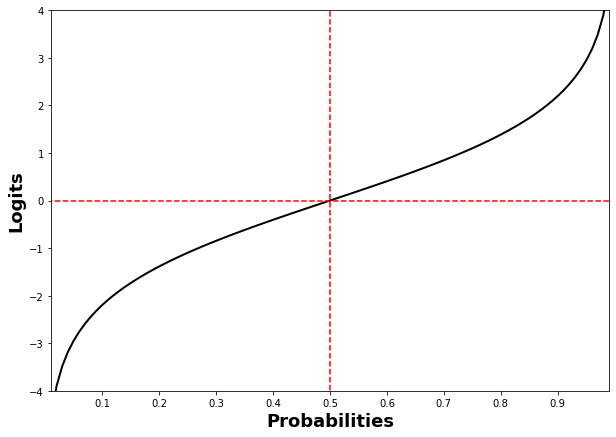

In [95]:
def logit(p):
    return np.log(p/(1-p))

xs = np.linspace(1e-2,0.99, 100)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(xs, logit(xs), lw=2, c="k")
ax.set_xticks(ticks=np.linspace(0,1,11))
ax.vlines(0.5, *ax.get_ylim(), ls="--", color="red")
ax.hlines(0,   *ax.get_xlim(), ls="--", color="red")


ax.set_xlim(min(xs), max(xs))
ax.set_ylim(-4,4)
ax.set_xlabel("Probabilities", **font)
ax.set_ylabel("Logits", **font)

plt.show()

Si aplicamos esta función a nuestros datos de prueba obtendríamos:

In [96]:
y_cpred_logit = logit(y_cpred)
y_cpred_logit 

array([[ 3.82360828,  1.38104366, -0.15438849,  1.26875282],
       [-2.0088733 ,  0.57502137, -1.78771347,  2.83749968],
       [ 0.08744897, -0.34472597, -1.02242344,  1.23237331],
       [-0.17585043,  0.27546455, -3.95547251,  0.47952412],
       [ 0.45613008,  0.47655474,  2.82001906,  0.76214981],
       [-0.57750063, -0.25321656,  0.83604311, -2.7475446 ],
       [ 0.69359743,  0.71107146, -1.32262098, -1.91048569],
       [-0.77486175, -0.55929426,  0.28265401, -0.24683968],
       [ 4.44280311, -2.17470813, -1.33170937, -1.64851673],
       [ 0.63273045, -1.08113334, -0.13496139, -1.12856733]])

In [97]:
# Valor de la función de perdida para cada batch usando logits
loss_bce_logit = keras.losses.BinaryCrossentropy(reduction=keras.losses.Reduction.NONE, from_logits=True)
loss_bce_logit(y_true=y_ctrue, y_pred=y_cpred_logit)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.589818  , 1.1451306 , 1.0871572 , 0.53857553, 1.2918621 ,
       0.42386186, 1.2764452 , 0.68625593, 0.87744266, 0.8687841 ],
      dtype=float32)>

Como podemos ver, los resultados coinciden, tanto de cuando usamos solamente las probabilidades a cuando usamos los logits.

**¿Cuándo usar los logits?** 
Cuando se usa un algoritmo de Deep Learning para problemas de clasificación, este habitualmente generará un vector con valores NO normalizados, el objetivo es convertir este vector a uno de probabilidades (normalizado), cuando le decimos a la función de costo que está recibiendo logits, esta los convierte en probabilidades para poder ser interpretados como ya hemos explicado previamente. A modo más general, los logits son la entrada para la función de activación [*softmax*](https://es.wikipedia.org/wiki/Funci%C3%B3n_SoftMax) que estuvimos utilizando como función de activación en la última capa de los ejemplos anteriores, ahora entendemos mejor el porqué de esa elección, softmax convierte los logits a probabilidades. 

### Categorical cross-entropy (CCE)
Para problemas de clasificación con más de dos clases una de las primeras opciones que tenemos es Categorical Cross Entropy (CCE): 

\begin{equation}
\text{CCE} = -\sum_{c=1}^{N}\log(\hat y_c)
\end{equation}

Donde los $\hat y_c$ son las probabilidades de pertenecer a la clase $c$ con $c=1,2,...N$ y vienen dados a partir de la función softmax:

\begin{equation}
\hat y_c = \frac{\text{exp}(x_c)}{\sum_{c=1}^{N}\text{exp}(x_c)}
\end{equation}

$x_c$ representa la $c-$ésima entrada del vector de salida. Usando las dos últimas expresiones:

\begin{equation}
\text{CCE} = -\sum_{c=1}^{N}\log\frac{\text{exp}(x_c)}{\sum_{i=1}^{N}\text{exp}(x_i)}
\end{equation}

Creemos algunos datos de prueba aleatoriamente. Supongamos vamos a realizar una clasificación multiclase entre $3$ posibles clases, para ello se crearán $10$ batches, cada uno con cuatro muestras, es decir, $40$ muestras en total, cada una conteniendo un vector con un único $1$ indicando la clase a la que pertenese la muestra:

In [98]:
np.random.seed(2)

# y_true
cs = 3
ops = np.diag(np.ones(cs, dtype=int))
y_ctrue = np.array([ops[np.random.choice(np.arange(cs))] for _ in range(40)]).reshape((10,4,-1))

# Los valores predichos deben ser probabilidades (usamos softmax para lograr esto)
y_cpred = np.random.uniform(low=-5, high=5, size=y_ctrue.shape)
y_cpred = np.exp(y_cpred)/np.sum(np.exp(y_cpred), axis=2).reshape((*y_ctrue.shape[0:2],-1))

In [99]:
y_ctrue

array([[[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]],

       [[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]],

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]],

       [[1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]],

       [[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]])

In [100]:
y_cpred

array([[[3.02683375e-02, 1.93645309e-01, 7.76086354e-01],
        [3.55537709e-02, 2.15575314e-02, 9.42888698e-01],
        [6.55903618e-04, 8.77269029e-04, 9.98466827e-01],
        [7.86192686e-03, 4.22938806e-04, 9.91715134e-01]],

       [[7.08378063e-03, 4.02355023e-03, 9.88892669e-01],
        [2.18170567e-01, 6.83309786e-01, 9.85196463e-02],
        [1.50386178e-01, 1.76370476e-01, 6.73243346e-01],
        [9.53735446e-01, 4.39446605e-02, 2.31989390e-03]],

       [[1.93558415e-01, 8.28662669e-03, 7.98154959e-01],
        [9.05802117e-01, 1.13249738e-02, 8.28729095e-02],
        [7.26976019e-02, 7.62251140e-03, 9.19679887e-01],
        [3.32015866e-02, 1.18356307e-02, 9.54962783e-01]],

       [[8.88901833e-01, 9.71128388e-02, 1.39853283e-02],
        [9.24853174e-01, 3.38269366e-02, 4.13198895e-02],
        [4.83881635e-03, 9.95061646e-01, 9.95377192e-05],
        [9.71042688e-01, 2.33575847e-02, 5.59972695e-03]],

       [[5.66080159e-03, 9.88604413e-01, 5.73478527e-03],
      

Cada una de las predicciones debe corresponder a un vector de probabilidad donde la suma de todas sea $1$:

In [101]:
np.sum(y_cpred, axis=2)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

Apliquemos ahora la función de perdida CCE:

In [102]:
loss_cce = keras.losses.CategoricalCrossentropy(reduction="none")
loss_cce(y_true=y_ctrue, y_pred=y_cpred)

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[3.49765301e+00, 3.83702993e+00, 7.32949686e+00, 8.31937697e-03],
       [1.11694727e-02, 1.52247810e+00, 3.95648450e-01, 3.12482405e+00],
       [4.79311228e+00, 2.49044704e+00, 2.62144685e+00, 3.40515757e+00],
       [1.17768474e-01, 3.38649797e+00, 9.21497440e+00, 2.93848440e-02],
       [5.16120481e+00, 2.20193967e-01, 2.10138869e+00, 5.81267643e+00],
       [1.77362967e+00, 6.55489254e+00, 4.52238369e+00, 4.63530004e-01],
       [1.01794213e-01, 7.40520298e-01, 5.51251650e-01, 1.03699183e+00],
       [1.14602959e+00, 3.11085016e-01, 6.59828281e+00, 8.52352047e+00],
       [4.26666832e+00, 3.84961295e+00, 5.96150446e+00, 1.20050646e-01],
       [2.13322282e+00, 8.12287140e+00, 2.03960562e+00, 5.30768967e+00]],
      dtype=float32)>

In [103]:
# Con numpy
-np.sum(y_ctrue*np.log(y_cpred), axis=2)

array([[3.49765308e+00, 3.83703004e+00, 7.32949670e+00, 8.31937590e-03],
       [1.11694779e-02, 1.52247810e+00, 3.95648431e-01, 3.12482415e+00],
       [4.79311231e+00, 2.49044706e+00, 2.62144688e+00, 3.40515762e+00],
       [1.17768474e-01, 3.38649785e+00, 9.21497390e+00, 2.93848484e-02],
       [5.16120497e+00, 2.20193939e-01, 2.10138876e+00, 5.81267651e+00],
       [1.77362969e+00, 6.55489281e+00, 4.52238376e+00, 4.63530047e-01],
       [1.01794190e-01, 7.40520300e-01, 5.51251659e-01, 1.03699178e+00],
       [1.14602959e+00, 3.11085028e-01, 6.59828303e+00, 8.52352058e+00],
       [4.26666842e+00, 3.84961298e+00, 5.96150443e+00, 1.20050624e-01],
       [2.13322279e+00, 8.12287156e+00, 2.03960557e+00, 5.30768979e+00]])

**Nota:** Es importante notar que el caso binario BCE es un caso especial de CCE. Cuando usamos CCE se suma el logaritmo de las probabilidades de cada una de las clases y luego multiplicamos por menos. Pues bueno, la expresión $\text{BCE} = -\left[y_i \log(\hat y_i) + (1-y_i)\log(1-\hat y_i) \right]$ suma el logaritmo de dos probabilidades, $\log(\hat y_i)$ para la clase positiva $1$ y $\log(1-\hat y_i)$ para la clase negativa $0$. Esto lo podemos ver más fácilmente al recordar que $\hat y_i$ es la probabilidad de la clase positiva por lo que $1-\hat y_i$ representa la probabilidad de la clase negativa (la suma de las probabilidades debe ser $1$).

### Sparse categorical cross-entropy (SCCE)

SCCE utiliza la misma función de perdida que CCE, la diferencia está en cómo se entregan los $y_i$. En el caso de CCE se usa un vector One-Hot Encoding. Por ejemplo, continuando con la lógica del ejemplo anterior, podríamos utilizar el vector $[0,1,0]$ para decir que la muestra pertenece a la clase $1$. Si usamos SCCE entregaríamos un vector conteniendo la clase de cada muestra, no un vector en formato One-Hot Encoding. 

Realicemos el ejemplo con los mismos datos que generamos para CCE. Primero convirtámolos a un vector conteniendo solamente el índice de la clase:

In [104]:
# Original
y_ctrue

array([[[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]],

       [[0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0]],

       [[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]],

       [[0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]],

       [[1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]],

       [[0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1]]])

In [105]:
# Indices
y_ctrue_id = np.argmax(y_ctrue, axis=2) 
y_ctrue_id

array([[0, 1, 0, 2],
       [2, 0, 2, 1],
       [1, 2, 0, 0],
       [0, 1, 2, 0],
       [2, 2, 2, 1],
       [2, 0, 1, 0],
       [0, 2, 2, 1],
       [2, 0, 0, 2],
       [0, 2, 0, 2],
       [1, 2, 0, 2]])

In [106]:
loss_scce = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_scce(y_true=y_ctrue_id, y_pred=y_cpred)

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[3.49765301e+00, 3.83702993e+00, 7.32949686e+00, 8.31936579e-03],
       [1.11695258e-02, 1.52247810e+00, 3.95648450e-01, 3.12482405e+00],
       [4.79311228e+00, 2.49044704e+00, 2.62144709e+00, 3.40515757e+00],
       [1.17768414e-01, 3.38649797e+00, 9.21497440e+00, 2.93849222e-02],
       [5.16120481e+00, 2.20193967e-01, 2.10138869e+00, 5.81267643e+00],
       [1.77362967e+00, 6.55489302e+00, 4.52238369e+00, 4.63530004e-01],
       [1.01794280e-01, 7.40520298e-01, 5.51251650e-01, 1.03699183e+00],
       [1.14602959e+00, 3.11084926e-01, 6.59828329e+00, 8.52352047e+00],
       [4.26666832e+00, 3.84961295e+00, 5.96150446e+00, 1.20050631e-01],
       [2.13322282e+00, 8.12287140e+00, 2.03960562e+00, 5.30768919e+00]],
      dtype=float32)>

Este resultado coincide con el obtenido al utilizar CCE. 

El uso de SCCE es preferido sobre CCE si tenemos el label de la clase y no el vector en formato One-Hot Encoding. Ya que sólo se necesita un índice y no un vector completo SCCE es más eficiente que CCE en el manejo de memoria.

### Hinge Loss
Otra función de perdida para problemas de clasificación binaria es la función de perdida de [Hinge](https://en.wikipedia.org/wiki/Hinge_loss) que se define como:

\begin{equation}
\text{Hinge} = \text{max}(0, 1-y\hat y)
\end{equation}

Para utilizar esta función las clases deben estar en el conjunto $\{-1, 1\}$. $y$ representa la clase verdadera $1$ o $-1$, $\hat y$ representa el valor de salida de la red sin ser convertido a probabilidades, es decir, puede ser tanto positivo como negativo. Para entender mejor esta función de costo consideremos las siguientes situaciones. Supongamos que tenemos una mala predicción para la clase $1$, es decir obtenemos un valor de $\hat y$ negativo entonces $1-y\hat y$ será positivo implicando que la función de Hinge retornará un valor mayor a cero ($1-y\hat y$). Si obtenemos una buena predicción, es decir $y$ y $\hat y$ coinciden en signo y $|\hat y|\geq 1$, entonces la cantidad $1-y\hat y$ será negativa y por lo tanto Hinge retornará $0$. En caso que la predicción sea correcta pero $|\hat y|<1$ entonces Hinge igualmente penalizará la predicción pero aportando muy poco a la función de perdida, esto implica que Hinge obligará a la red a maximizar la distancia entre las clases y el hiperplano quelas separa.

Esta función es altamente utilizada para problemas con SVM pues ayuda a maximizar la margen de separación entre las dos clases. Para entender un poco mejor esto, vemos que la cantidad $1-y\hat y$ será negativa solamente si $y\hat y \geq 1$, que es cuando el modelo predice correctamente. Pues bien, si recordamos $y\hat y \geq 1$ es precisamente la condición bajo la cual se minimizan las SVM. 

Veamos un ejemplo:

In [107]:
# Estos son los mismos datos utilizados para BCE pero cambiando los labels
np.random.seed(0)
y_ctrue = np.random.randint(0, 2, (10,4))
y_ctrue[y_ctrue==0] = -1

# Los valores predichos son probabilidades
y_cpred = np.random.uniform(low=-10, high=10, size=y_ctrue.shape)
y_ctrue

array([[-1,  1,  1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1, -1],
       [-1,  1, -1, -1],
       [-1, -1, -1,  1],
       [-1,  1,  1, -1],
       [-1,  1,  1,  1],
       [ 1, -1,  1, -1],
       [ 1, -1,  1,  1],
       [-1,  1,  1, -1]])

In [108]:
loss_hinge = keras.losses.Hinge(reduction=None)
loss_hinge(y_true=y_ctrue, y_pred=y_cpred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([4.7383404 , 4.1918616 , 3.865839  , 0.86892915, 4.113889  ,
       0.5648402 , 4.8872895 , 1.1728582 , 3.6490686 , 2.9175296 ],
      dtype=float32)>

In [109]:
# numpy
hinge = 1-y_ctrue*y_cpred
hinge[hinge<=0] = 0
hinge

array([[10.57236684,  0.        ,  1.77041275,  6.61058353],
       [ 8.63451148,  0.        ,  8.13293425,  0.        ],
       [ 0.56303356,  2.7067612 ,  5.70888776,  6.48467379],
       [ 0.12300664,  0.        ,  0.        ,  3.35270994],
       [ 3.24191445,  3.33867994,  9.87496157,  0.        ],
       [ 0.        ,  2.25936092,  0.        ,  0.        ],
       [ 4.33533431,  0.        ,  6.79234878,  8.42147405],
       [ 4.69143298,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  6.82246488,  7.77380964],
       [ 4.06216651,  5.93416795,  1.67378454,  0.        ]])

In [110]:
np.mean(hinge, axis=1)

array([4.73834078, 4.19186143, 3.86583908, 0.86892915, 4.11388899,
       0.56484023, 4.88728928, 1.17285825, 3.64906863, 2.91752975])

**Importante:** Cuando usamos Hinge debemos utilizar un único nodo en la capa de salida de la red con una función de activación $\text{tanh}$ pues su salida estará en el rango $(-1,1)$.

**Nota:** Hinge es preferida a BCE para aquellos casos en los cuales queramos un modelo menos sensible a outliers. Una desventaja respecto a BCE es que no proporciona probabilidades las cuales pueden ser muy deseadas a la hora de evaluar los resultados del modelo. Hinge, además, tenderá a maximizar la separación de las clases, esto lo podemos entender ya que su algoritmo está fuertemente ligado con la lógica detrás de las SVM. Una ventaja interesante de BCE sobre Hinge es la suavidad, Hinge no tiene un gradiente suave por lo que puede llevar a problemas de optimización. 
Cuál de las dos tiene un mejor desempeño no es absoluto, en ocasiones una podría funcionar mejor que la otra, por esto la elección dependerá siempre de los datos y las necesidades propias del modelo.

### Funciones de perdida personalizadas (Custom Loss Functions)
En caso que las funciones de perdida predefinidas en tensorflow no sean suficientes, podemos crear las nuestras propias. Para esto usamos las operaciones que TensorFlow nos ofrece. Veamos algunos ejemplos.

La función de perdida debe recibir dos argumentos, <code>y_true</code> y <code>y_pred</code>:

In [111]:
# Empecemos definiendo una sencilla: MAE
def custom_loss_1(y_true, y_pred, reduction="sum_over_batch_size"):
    if reduction=="sum_over_batch_size": return tf.reduce_mean(tf.abs(y_true - y_pred))
    if reduction=="none": return tf.reduce_mean(tf.abs(y_true - y_pred), axis=-1)

custom_loss_1(y_true=y_true, y_pred=y_pred, reduction="sum_over_batch_size")

<tf.Tensor: shape=(), dtype=float64, numpy=6.692670113807388>

In [112]:
loss_mae(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 3.4072087,  8.105146 ,  4.1989875,  8.257989 ,  8.016254 ,
        3.346784 ,  5.6329627,  4.4460154,  8.105422 , 13.40993  ],
      dtype=float32)>

In [113]:
# Hinge (diferenciable)
def custom_loss_2(y_true, y_pred, reduction="sum_over_batch_size"):
    if reduction=="none":
        return tf.reduce_mean(tf.maximum(1-y_true*y_pred,
                                         0), axis=-1)
    
    if reduction=="sum_over_batch_size":
        return tf.reduce_mean(tf.maximum(1-y_true*y_pred, 0))
    
# otra aproximación (no diferenciable)
def custom_loss_3(y_true, y_pred, reduction="sum_over_batch_size"):
    if reduction=="none":
        return tf.reduce_mean(tf.where(tf.greater(1-y_ctrue*y_cpred, 0),
                                       x=1-y_ctrue*y_cpred,
                                       y=0), axis=-1)
    
    if reduction=="sum_over_batch_size": 
        return tf.reduce_mean(tf.where(tf.greater(1-y_ctrue*y_cpred, 0),
                                       x=1-y_ctrue*y_cpred,
                                       y=0))

In [114]:
custom_loss_2(y_true=y_ctrue, y_pred=y_cpred, reduction="none")

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([4.73834078, 4.19186143, 3.86583908, 0.86892915, 4.11388899,
       0.56484023, 4.88728928, 1.17285825, 3.64906863, 2.91752975])>

In [115]:
custom_loss_3(y_true=y_ctrue, y_pred=y_cpred, reduction="none")

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([4.73834078, 4.19186143, 3.86583908, 0.86892915, 4.11388899,
       0.56484023, 4.88728928, 1.17285825, 3.64906863, 2.91752975])>

#### Problemas al definir la función de costo
Tanto al definir una función de costo como una función de activación debemos garantizar que sean diferenciables. TensorFlow calcula internamente la derivada de la función para poder ejecutar el algoritmo de back propagation, por esta razón debemos asegurarnos que la función que entregemos sea diferenciable, de lo contrario obtendremos un error como el que se ve en la figura:

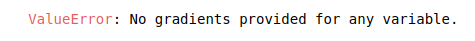

indicando esto que no se pudo calcular el gradiente de la función de perdida entregada. Por ejemplo, en las celdas anteriores definimos dos funciones de perdida que en principio hacen la misma tarea, calcular la función de Hinge. La función <code>custom_loss_2</code> es diferenciable, por lo tanto es posible utilizarla como función de perdida, la función <code>custom_loss_3</code> no lo es (¿por qué?) por lo cual no puede ser utilizada como función de perdida. Aunque ambas funciones realizan la misma tarea, no lo hacen de igual forma, es importante tener presente este comportamiento a la hora de definir nuestras funciones de perdida/activación. 

Una lista de errores producidos por malas definiciones de la función de perdida se puede encontrar en el [enlace](https://github.com/keras-team/tf-keras/issues/52). 

### La función de perdida y la convergencia
Como ya se ha mencionado, el objetivo de las funciones de activación es servir como indicador del desempeño del modelo, un mayoe valor indica, en principio, un mal desempeño, pero no todo es blanco o negro acá, si bien el objetivo es minimizar la función de costo, también se debe tener cuidado para evitar que el modelo se sobreentrene. A modo general, cuando logramos encontrar un mínimo estable para la función de costo decimos que hemos **convergido** a una solución. Se debe tener cuidado con la solución encontrada, la existencia de mínimos locales puede desviar el algoritmo de encontrar el mínimo global, el cual es el verdadero objetivo. Para eludir los problemas mencionados existen varias técnicas que más adelante se abordarán, por ahora concentrémonos en cómo se debería dar el comportamiento de la función de costo luego de cada época. 

Una buena señal de convergencia de la función de costo es cuando su valor disminuye después de cada época. A medida que avance el proceso de optimización la reducción debe ser cada vez menor indicando que nos encontramos cerca del mínimo global. 

Veamos a continuación el uso de dos funciones de perdida diferentes y su impacto sobre el desempeño de un modelo para clasificar números entre mayores o menores a $5$.

**Con BBC**

In [116]:
# modelo
model_bce = create_model(name="model_loss_bce", 
                         shape=train_images[0].shape,
                         af="relu",
                         output_af="sigmoid",
                         output_nodes=1)

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
model_bce.compile(optimizer=opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=["accuracy"])

model_bce.summary()

Model: "model_loss_bce"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,931 (327.86 KB)

 Trainable params: 83,931 (327.86 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
train_labels_custum = train_labels.astype(int).copy()
test_labels_custum  = test_labels.astype(int).copy()

train_labels_custum[train_labels<=5] = 0
train_labels_custum[train_labels>5]  = 1

test_labels_custum[test_labels<=5] = 0
test_labels_custum[test_labels>5]  = 1

history_loss_bce = model_bce.fit(train_images,
                                 train_labels_custum.astype("uint8"),
                                 validation_split=0.2,
                                 epochs=15)

history_loss_bce = history_loss_bce.history

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8737 - loss: 0.2951 - val_accuracy: 0.9121 - val_loss: 0.2051
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9201 - loss: 0.1903 - val_accuracy: 0.9155 - val_loss: 0.1904
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9275 - loss: 0.1743 - val_accuracy: 0.9201 - val_loss: 0.1909
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9331 - loss: 0.1651 - val_accuracy: 0.9277 - val_loss: 0.1726
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9340 - loss: 0.1553 - val_accuracy: 0.9316 - val_loss: 0.1598
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9385 - loss: 0.1501 - val_accuracy: 0.9332 - val_loss: 0.1562
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9406 - loss: 0.1414 - val_accuracy: 0.9340 - val_loss: 0.1742
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9400 - loss: 0.1432 - 

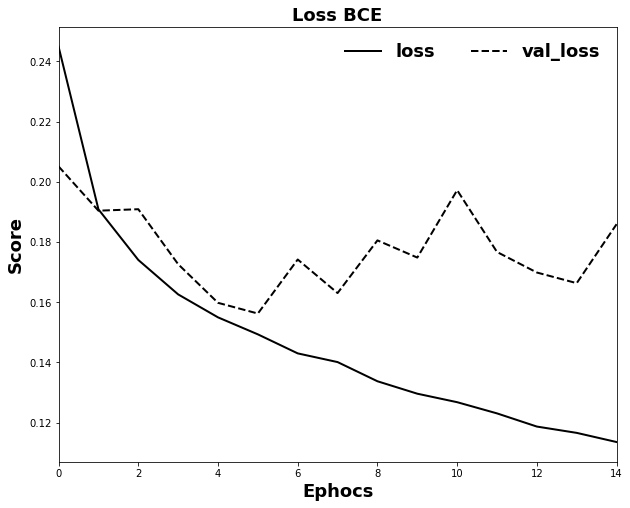

In [118]:
plot_accuracy_loss(history_loss_bce, name="Loss BCE", accuracy=False)

¿Cuál es la capacidad predictiva de este modelo?

In [119]:
# métricas entrenamiento
model_bce.evaluate(x=train_images, y=train_labels_custum)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9544 - loss: 0.1124


[0.1266382932662964, 0.9504500031471252]

In [120]:
# métricas testeo
model_bce.evaluate(x=test_images, y=test_labels_custum)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9354 - loss: 0.1886


[0.2026805430650711, 0.9316999912261963]

In [121]:
# prueba
for i,p in enumerate(model_bce.predict(x=test_images[:10])):
    print(f"pred: {p[0]:<23} --> {'n<=5' if p<=0.5 else 'n >5'}  real:{'<=5' if test_labels_custum[i]==0 else ' >5'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
pred: 0.9999960064888         --> n >5  real: >5
pred: 0.00044457611511461437  --> n<=5  real:<=5
pred: 1.619403349195636e-07   --> n<=5  real:<=5
pred: 1.6087998488956146e-08  --> n<=5  real:<=5
pred: 0.9802144169807434      --> n >5  real: >5
pred: 2.8691296392935328e-05  --> n<=5  real:<=5
pred: 0.0008972615469247103   --> n<=5  real:<=5
pred: 0.9975214004516602      --> n >5  real: >5
pred: 2.3775415058935323e-07  --> n<=5  real:<=5
pred: 1.0                     --> n >5  real: >5


**Con Hinge**

In [122]:
# modelo
# Como usamos Hinge sólo puede haber un nodo de salida con act=tanh
model_custom1 = create_model(name="custom_1", 
                             shape=train_images[0].shape,
                             af="relu",
                             output_af="tanh", output_nodes=1)

# compilación
opt  = keras.optimizers.Adam(learning_rate=0.001)
model_custom1.compile(optimizer=opt,
                      loss=keras.losses.Hinge(),
                      metrics=["accuracy"])

model_custom1.summary()

Model: "custom_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 80)             │        62,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_3 (Dense)                 │ (None, 80)             │         7,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_4 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,931 (327.86 KB)

 Trainable params: 83,931 (327.86 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
# Para Hinge necesitamos sólo dos clases, 1 y -1
train_labels_custom = train_labels.astype(int).copy()
test_labels_custum  = test_labels.astype(int).copy()

train_labels_custom[train_labels<=5] = -1
train_labels_custom[train_labels>5]  =  1

test_labels_custum[test_labels<=5] = -1
test_labels_custum[test_labels>5]  =  1

history_loss_custom1 = model_custom1.fit(train_images,
                  train_labels_custom,
                  validation_split=0.2,
                  epochs=15)

history_loss_custom1 = history_loss_custom1.history

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2827 - loss: 0.3173 - val_accuracy: 0.2954 - val_loss: 0.2522
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2968 - loss: 0.2778 - val_accuracy: 0.2878 - val_loss: 0.2419
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2945 - loss: 0.2687 - val_accuracy: 0.2918 - val_loss: 0.2388
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2956 - loss: 0.2517 - val_accuracy: 0.2816 - val_loss: 0.2523
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2989 - loss: 0.2639 - val_accuracy: 0.2288 - val_loss: 0.3329
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2858 - loss: 0.2719 - val_accuracy: 0.2791 - val_loss: 0.2603
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2842 - loss: 0.2703 - val_accuracy: 0.2932 - val_loss: 0.2453
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3141 - loss: 0.2765 -

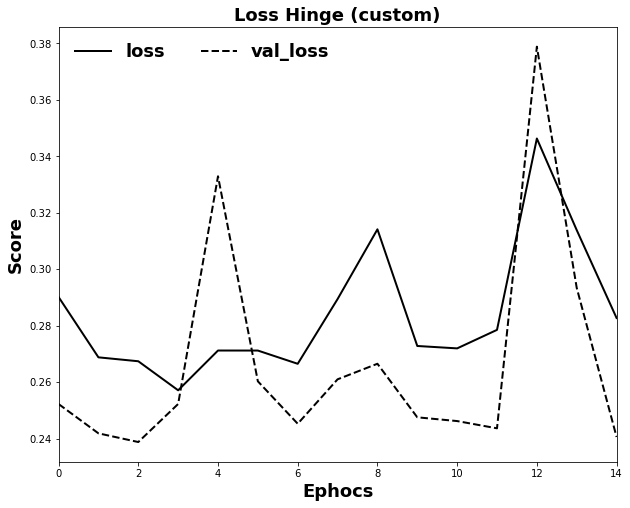

In [124]:
plot_accuracy_loss(history_loss_custom1, name="Loss Hinge (custom)", accuracy=False)

In [125]:
# métricas entrenamiento
model_custom1.evaluate(x=train_images, y=train_labels_custum)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8767 - loss: 0.2467


[0.24641606211662292, 0.876800000667572]

In [126]:
# métricas testeo
model_custom1.evaluate(x=test_images, y=test_labels_custum)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2839 - loss: 0.2448


[0.24981895089149475, 0.2906000018119812]

In [127]:
# prueba
for i,p in enumerate(model_custom1.predict(x=test_images[:10])):
    print(f"pred: {p[0]:<4} --> {'n<=5' if p==-1 else 'n >5'}  real:{'<=5' if test_labels_custum[i]==-1 else ' >5'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
pred: 1.0  --> n >5  real: >5
pred: -1.0 --> n<=5  real:<=5
pred: -1.0 --> n<=5  real:<=5
pred: -1.0 --> n<=5  real:<=5
pred: -1.0 --> n<=5  real: >5
pred: -1.0 --> n<=5  real:<=5
pred: -1.0 --> n<=5  real:<=5
pred: -1.0 --> n<=5  real: >5
pred: -1.0 --> n<=5  real:<=5
pred: 1.0  --> n >5  real: >5


<center><h1>Optimizadores</h1></center>

Un optimizador es la herramienta utilizada para minimizar la función de costo, no importa cuál utilicemos, todos tendrán por objetivo hallar los valores de los pesos $w_i$ de la red neuronal que producen el mejor desempeño del modelo. Como ya se ha explicado previamente, durante cada época los datos se arreglan en lotes, o batches, cada vez que se calcula la función de perdida para un batch su valor se utiliza para actualizar los pesos mediante el uso del respectivo optimizador de modo que, después de cada actualización, se produce una mejora en las métricas del modelo representadas en una disminución del valor de la función de costo, bueno, eso es lo esperado. 

La idea fundamental detrás de los algoritmos de optimización es la del [gradiente descendente](https://es.wikipedia.org/wiki/Descenso_del_gradiente). Esta consiste básicamente es moverse con pequeños pasos sobre la función de costo siguiendo la dirección contraria a su [gradiente](https://es.wikipedia.org/wiki/Gradiente) en el punto en el que nos encontremos. Para entenderlo mejor, recordemos que una de las propiedades más importantes del gradiente es que es un vector que apunta siempre en la dirección de mayor crecimiento de la función, así que si nos movemos en dirección contraria a este estariamos yendo hacia donde la función menos crece, es dcir, su mínimo, lo cual es nuestro objetivo; hallar el mínimo de la función de costo. 

Matemáticamente esto se puede expresar como 
\begin{equation}
\textbf w_{i+1} = \textbf w_{i} - \eta \nabla \text{f}(\textbf w_{i})
\end{equation}

donde $\eta$ es conocido como la [**tasa de aprendizaje**](https://en.wikipedia.org/wiki/Learning_rate) o **learning ratio** y determina el tamaño de los pasos que se irán dando durante cada actualización de los pesos. Su valor suele ser pequeño y es fundamental, si es muy grande los pasos podrían ser tales que se saltasen el punto mínimo de modo que nunca se encontraría, si es muy pequeño podría nunca llegar a encontrarlo o tardarse demasiado. 

A continuación definimos una rutina simple que calcula el gradiente desendente a partir del gradiente de la función.

In [10]:
# Rutina para un gradiente descendente
def GD(df, x0=[0], eta=0.1, tol=1e-10, max_iter=1000, history=True):
    xs = [x0]
    x0 = np.array(x0)
    
    current_iter = 1
    while current_iter<max_iter:
        # Gradiente descendente
        x1 = x0 - eta*df(*x0)
        xs.append(x1)
        
        # Corrobora tolerancia
        if all([abs(x0[i]-x1[i])<tol for i in range(len(x0))]):break
        
        # Actualización
        x0 = x1
        current_iter+=1
    
    sol = {"x":xs[-1],
           "iteraciones":current_iter,
           "tol_param":abs(x0-x1)}
    
    if history: sol["history"] = np.array(xs)
    
    return sol

Como podemos ver, es necesario definir el nivel máximo de tolerancia $tol$ que estamos dispuestos a aceptar en nuestra respuesta. Además de esto, hay que dar un valor inicial con el cual se comenzará la búsqueda $x_0$, habitualmente este se fija en $\textbf 0$, es decir, todos los parámetros en $0$. Veamos algunos ejemplos aplicando la anterior rutina.

In [152]:
# f(x) = 2x² - 5x + 1
def df1(x): return 4*x-5

# f(x,y) = x² + 3y² - 5x + 2y - 3xy
def df2(x, y): return np.array([2*x-5-3*y, 6*y+2-3*x]) 

sol_gd_proof1 = GD(df=df1, x0=[0])
sol_gd_proof2 = GD(df=df2, x0=[0,11], eta=0.2)

In [153]:
sol_gd_proof1

{'x': array([1.25]),
 'iteraciones': 45,
 'tol_param': array([8.66213767e-11]),
 'history': array([[0.        ],
        [0.5       ],
        [0.8       ],
        [0.98      ],
        [1.088     ],
        [1.1528    ],
        [1.19168   ],
        [1.215008  ],
        [1.2290048 ],
        [1.23740288],
        [1.24244173],
        [1.24546504],
        [1.24727902],
        [1.24836741],
        [1.24902045],
        [1.24941227],
        [1.24964736],
        [1.24978842],
        [1.24987305],
        [1.24992383],
        [1.2499543 ],
        [1.24997258],
        [1.24998355],
        [1.24999013],
        [1.24999408],
        [1.24999645],
        [1.24999787],
        [1.24999872],
        [1.24999923],
        [1.24999954],
        [1.24999972],
        [1.24999983],
        [1.2499999 ],
        [1.24999994],
        [1.24999996],
        [1.24999998],
        [1.24999999],
        [1.24999999],
        [1.25      ],
        [1.25      ],
        [1.25      ],
       

In [155]:
sol_gd_proof2

{'x': array([8.        , 3.66666667]),
 'iteraciones': 265,
 'tol_param': array([9.46389633e-11, 5.06474862e-11]),
 'history': array([[ 0.        , 11.        ],
        [ 7.6       , -2.6       ],
        [ 4.        ,  4.68      ],
        [ 6.208     ,  1.064     ],
        [ 5.3632    ,  3.112     ],
        [ 6.08512   ,  2.19552   ],
        [ 5.968384  ,  2.811968  ],
        [ 6.2682112 ,  2.6186368 ],
        [ 6.3321088 ,  2.83719936],
        [ 6.5015849 ,  2.83182541],
        [ 6.60004618,  2.93458586],
        [ 6.72077922,  2.97311054],
        [ 6.81633386,  3.03784543],
        [ 6.91250757,  3.08223123],
        [ 6.99684328,  3.1310583 ],
        [ 7.07674095,  3.17189431],
        [ 7.14918115,  3.21166571],
        [ 7.21650811,  3.24717555],
        [ 7.2782102 ,  3.28046976],
        [ 7.33520797,  3.31083217],
        [ 7.38762409,  3.33895835],
        [ 7.43594946,  3.36478278],
        [ 7.48043935,  3.38861312],
        [ 7.52143148,  3.41054098],
        [ 

Veamos esto un poco graficamente. Para la primera función:

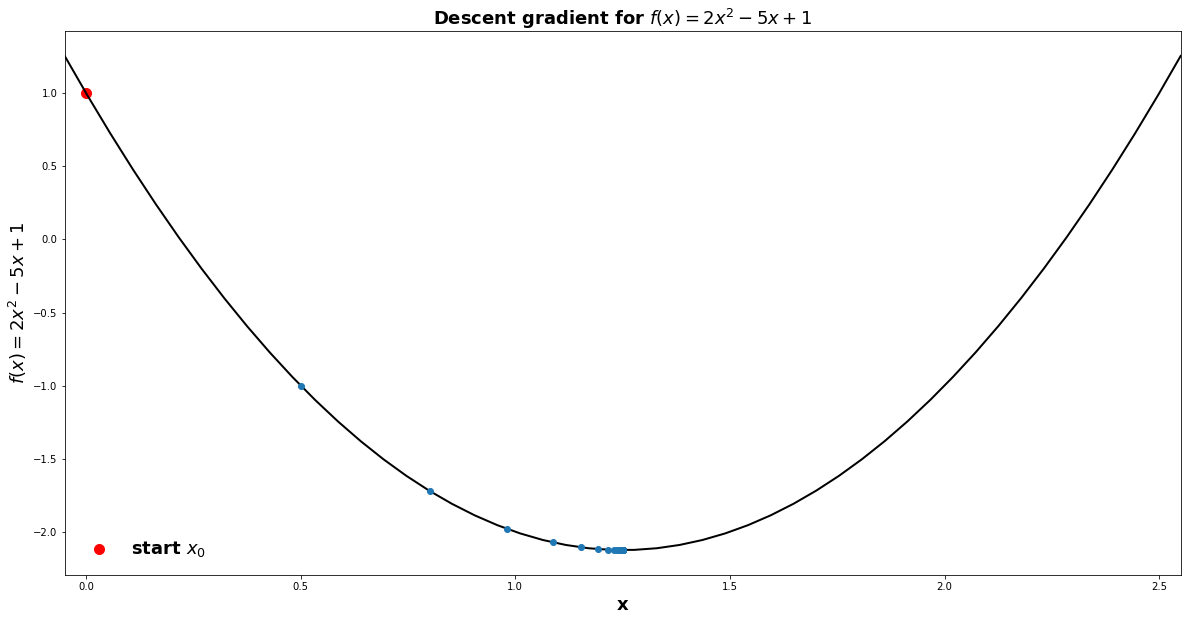

In [57]:
fig, ax = plt.subplots(figsize=(20,10))

# function
f = lambda x: 2*x**2-5*x+1
xs = np.linspace(sol_gd_proof1['x'][0]-1.3, sol_gd_proof1['x'][0]+1.3)
ax.plot(xs, f(xs) , c="black", lw=2)

# gradient descent
ax.scatter(sol_gd_proof1['history'][0], f(sol_gd_proof1['history'][0]), c="red", s=100, label="start $x_{0}$")
ax.plot(sol_gd_proof1['history'][1:], f(sol_gd_proof1['history'][1:]), "o")

ax.set_title("Descent gradient for $f(x)=2x^2-5x+1$", **font)
ax.set_xlabel("x", **font)
ax.set_ylabel("$f(x)=2x^2-5x+1$", **font)

ax.set_xlim(min(xs), max(xs))
plt.legend(frameon=False, prop=font)
plt.show()

Acá podemos ver que a medida que nos acercamos al punto mínimo el valor del gradiente disminuye haciendo los pasos más pequeños. Veamos para el caso tridimensional. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


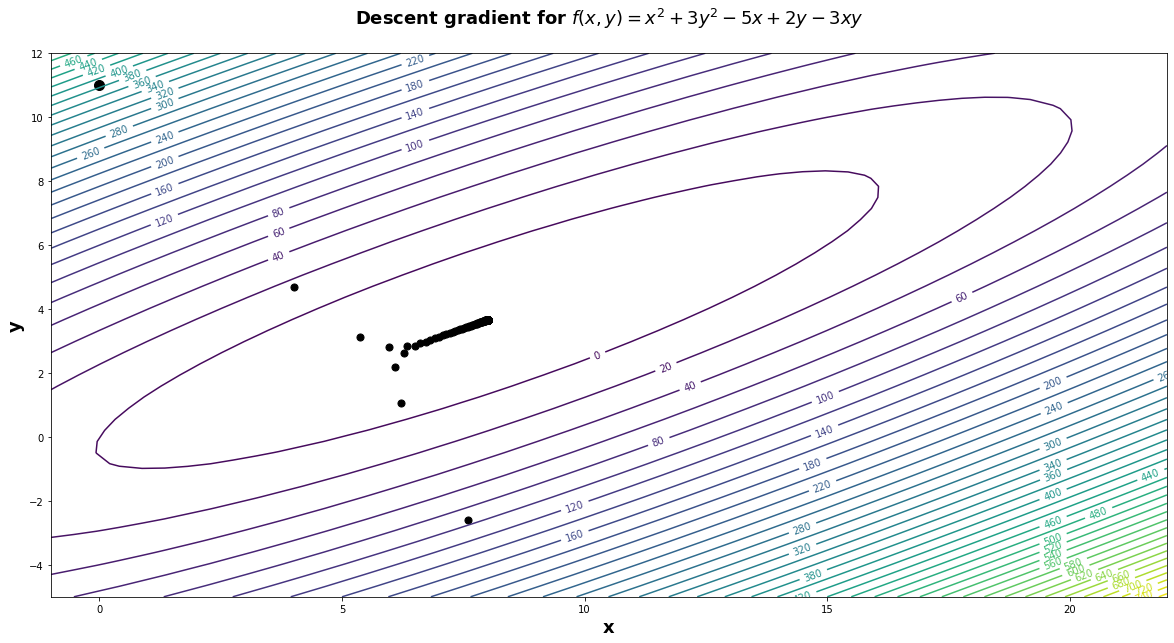

In [172]:
fig, ax = plt.subplots(figsize=(20,10))

# function x² + 3y² - 5x + 2y - 3xy
def f(x,y):
    return x**2 + 3*y**2 - 5*x + 2*y - 3*x*y

xs, ys = np.meshgrid(np.linspace(-1, 22), 
                     np.linspace(-5,12))
zs = f(xs, ys)
cs = ax.contour(xs, ys, zs, 50)
ax.clabel(cs)

# gradiend descent
ax.scatter(sol_gd_proof2['history'][0][0], sol_gd_proof2['history'][0][1], c="k", s=100)
ax.scatter(sol_gd_proof2['history'][1:,0][::1], sol_gd_proof2['history'][1:,1][::1], c="k", s=50)

ax.set_title("Descent gradient for $f(x,y)=x^2+3y^2-5x+2y-3xy$\n", **font)
ax.set_xlabel("x", **font)
ax.set_ylabel("y", **font)

plt.legend(frameon=False, prop=font)
plt.show()
plt.show()

In [171]:
sol_gd_proof2['history']

array([[ 0.        , 11.        ],
       [ 7.6       , -2.6       ],
       [ 4.        ,  4.68      ],
       [ 6.208     ,  1.064     ],
       [ 5.3632    ,  3.112     ],
       [ 6.08512   ,  2.19552   ],
       [ 5.968384  ,  2.811968  ],
       [ 6.2682112 ,  2.6186368 ],
       [ 6.3321088 ,  2.83719936],
       [ 6.5015849 ,  2.83182541],
       [ 6.60004618,  2.93458586],
       [ 6.72077922,  2.97311054],
       [ 6.81633386,  3.03784543],
       [ 6.91250757,  3.08223123],
       [ 6.99684328,  3.1310583 ],
       [ 7.07674095,  3.17189431],
       [ 7.14918115,  3.21166571],
       [ 7.21650811,  3.24717555],
       [ 7.2782102 ,  3.28046976],
       [ 7.33520797,  3.31083217],
       [ 7.38762409,  3.33895835],
       [ 7.43594946,  3.36478278],
       [ 7.48043935,  3.38861312],
       [ 7.52143148,  3.41054098],
       [ 7.55918348,  3.43075069],
       [ 7.5939605 ,  3.44935995],
       [ 7.62599227,  3.46650431],
       [ 7.65549795,  3.4822945 ],
       [ 7.68267547,

Existe diversidad de algoritmos soportados por TensorFlow para desempeñar esta tarea, para fines de este curso estudiaremos los siguientes:
* SGD
* 
* 
* 

que son los de mayor uso.

0.0

<center><h1>Algoritmo de Backpropagation</h1></center>